In [1]:
from configparser import ConfigParser
import matplotlib.pyplot as plt
# import pandas as pd
import matplotlib as mpl
from matplotlib.gridspec import GridSpec
from hep_ml.metrics_utils import ks_2samp_weighted
import ROOT
from array import array

In [2]:
cfg = 'config/sphereConfig_bias.cfg'

config = ConfigParser()
config.optionxform = str
config.read(cfg)

base = config['file']['base']
data = config['file']['data']
pairing = config['pairing']['scheme']
# pairing_type = pairing.split('_')[0]

variables = config['BDT']['variables']
print(variables)
variables = variables.split(', ')

score = float(config['score']['threshold'])

dR6bmin, dEta6bmax, HX_pt, HY1_pt, HY2_pt, HX_dr, HY1_dr, HY2_dr, HX_m, HY1_m, HY2_m, HX_HY1_dEta, HY1_HY2_dEta, HY2_HX_dEta, HX_HY1_dPhi, HY1_HY2_dPhi, HY2_HX_dPhi, HX_costheta, HY1_costheta, HY2_costheta


In [3]:
indir = f"root://cmseos.fnal.gov/{base}"
datFileName = f"{indir}{data}"
datTree = Signal(datFileName)

In [4]:
region_type = 'sphere'
datTree.spherical_region(config)
datTree.bdt_process(region_type, config)

VR_center   = 178
SR_edge     = 30
CR_edge     = 45
--------------------
b tag score = 0.6
--------------------

.. training BDT in V_CR
.. calling reweight.GBReweighter
.. calling reweight.FoldingReweighter
.. calling reweighter.fit
.. predicting weights in CR
.. performing kstest
[SUCCESS] ks-val = 0.009
.. predicting weights in V_SR
[FAILURE] ks-val = 0.037
[FAILURE] ks-val = 0.024
.. training BDT in A_CR
.. calling reweight.GBReweighter
.. calling reweight.FoldingReweighter
.. calling reweighter.fit
[SUCCESS] ks-val = 0.006
.. predicting weights in A_SR



8.849846863428796
8.227161895906573


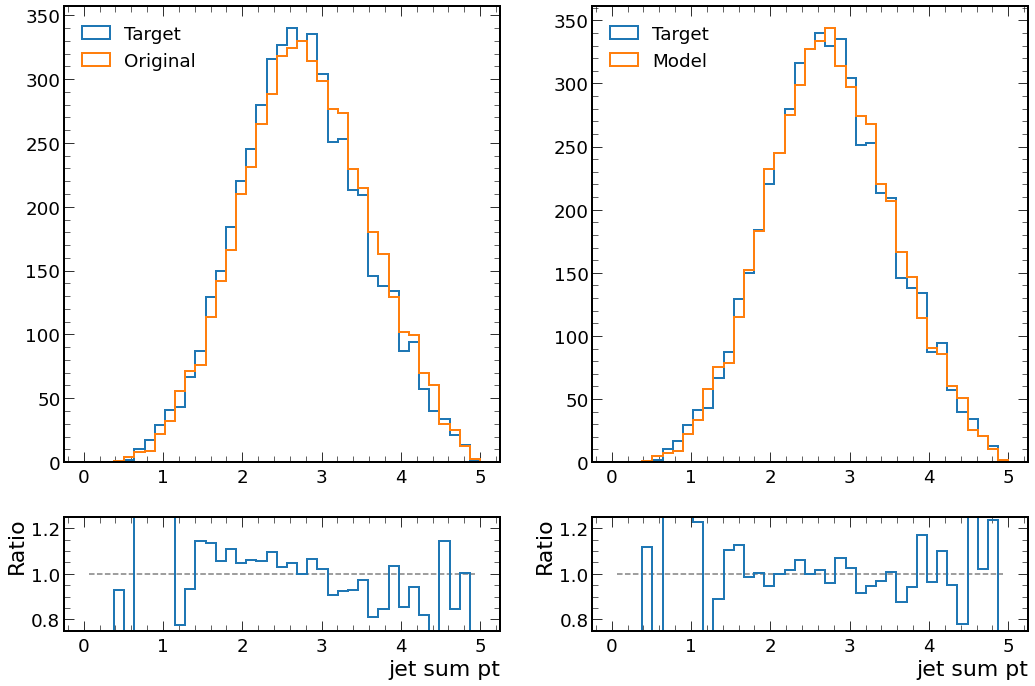

In [6]:
# bins = np.linspace(0, 1000, 100)
bins = np.linspace(0, 5, 40)
fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(15,10), gridspec_kw={'height_ratios':[4,1]})

target   = abs(datTree.np(variables[1]))[datTree.V_SRhs_mask]
original = abs(datTree.np(variables[1]))[datTree.V_SRls_mask]
ratio = len(target)/len(original)
norm = len(target)/sum(datTree.V_SR_weights)

_,_, d = Ratio([target, original], bins=bins, labels=['Target', 'Original'], weights=[None, np.repeat(ratio, len(original))], xlabel='jet sum pt', axs=[axs[0][0], axs[1][0]])
_,_, d = Ratio([target, original], bins=bins, labels=['Target', 'Model'], weights=[None, datTree.V_SR_weights*norm], xlabel='jet sum pt', axs=[axs[0][1], axs[1][1]])

axs[0][0].legend(loc=2)
axs[0][1].legend(loc=2)

plt.tight_layout()

In [8]:
from utils.files import *
from utils.plotter import Hist, Hist2d, Ratio
from utils.useCMSstyle import *
import awkward as ak
import numpy as np
np.seterr(all='ignore')
import matplotlib as mpl
import matplotlib.pyplot as plt

In [60]:
def plot_and_dist(var):
   print(var)
   target   = abs(datTree.np(var))[datTree.V_SRhs_mask]
   original = abs(datTree.np(var))[datTree.V_SRls_mask]
   ratio = len(target)/len(original)
   norm = len(target)/sum(datTree.V_SR_weights)

   xmax = max(np.concatenate((target, original)))
   xmin = min(np.concatenate((target, original)))
   bins = np.linspace(xmin, xmax, 40)

   fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(15,10), gridspec_kw={'height_ratios':[4,1]})

   _,_, d1 = Ratio([target, original], bins=bins, labels=['Target', 'Original'], weights=[None, np.repeat(ratio, len(original))], xlabel=var, axs=[axs[0][0], axs[1][0]])
   _,_, d2 = Ratio([target, original], bins=bins, labels=['Target', 'Model'], weights=[None, datTree.V_SR_weights*norm], xlabel=var, axs=[axs[0][1], axs[1][1]])

   axs[0][0].legend()
   axs[0][1].legend()

   plt.tight_layout()
   fig.savefig(f"plots/bdt_variables/{var}.pdf", bbox_inches='tight')

   dist = d2 - d1
   return dist

dR6bmin
8.81740144694052
8.922764454672809
dEta6bmax
6.478707360752512
5.825363010887243
HX_pt
16.21926887903469
18.808838837126217
HY1_pt
24.74175791880893
26.590828422781968
HY2_pt
20.98946912373072
22.505034938108682
HX_dr
8.056121394795948
9.572017311274877
HY1_dr
9.291821769205537
9.69688677823376
HY2_dr
17.157158494156867
16.324152574354713
HX_m
3.512384254859774
3.5336166407655965
HY1_m
4.316451027795091
4.457180710132973
HY2_m
4.524285716633925
4.7014790541932125
HX_HY1_dEta
11.162006343763053
11.549806514549747
HY1_HY2_dEta
13.260462723228027
14.79663953006122
HY2_HX_dEta
12.168253606234037
14.01652731504831
HX_HY1_dPhi
5.325817072081114
5.284226491412896
HY1_HY2_dPhi
3.140821703365792
3.0375207037642626
HY2_HX_dPhi
3.7534162715646944
3.95451815213755
HX_costheta
4.140617544355567
3.7614704175083453
HY1_costheta
4.433837252427142
4.009903673193609
HY2_costheta
6.039192438109197
5.4831433344367735


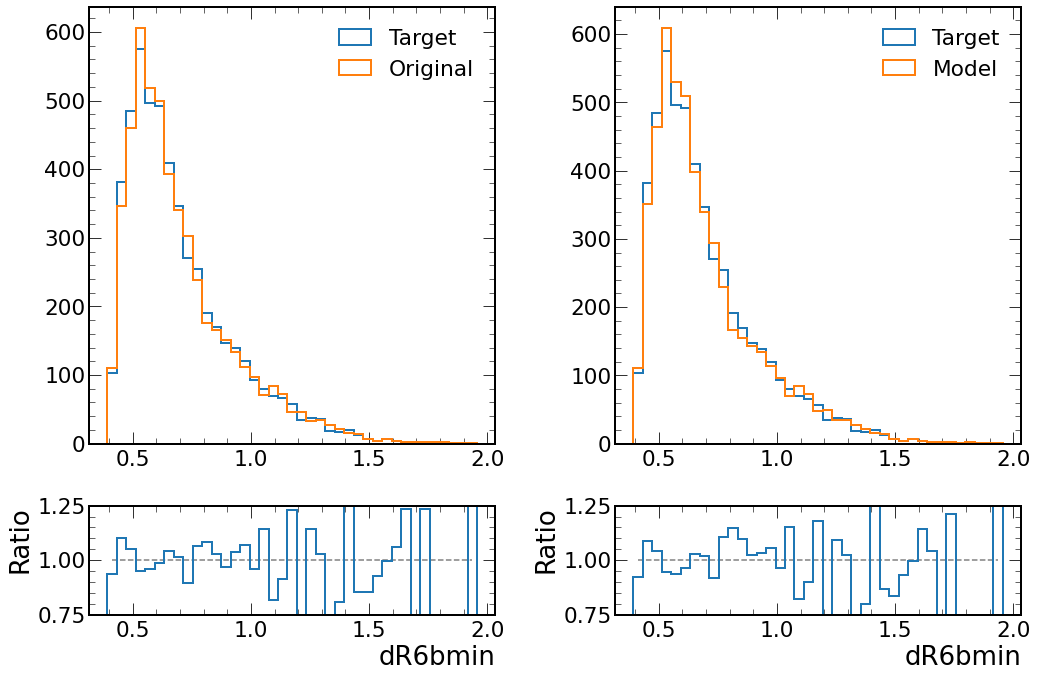

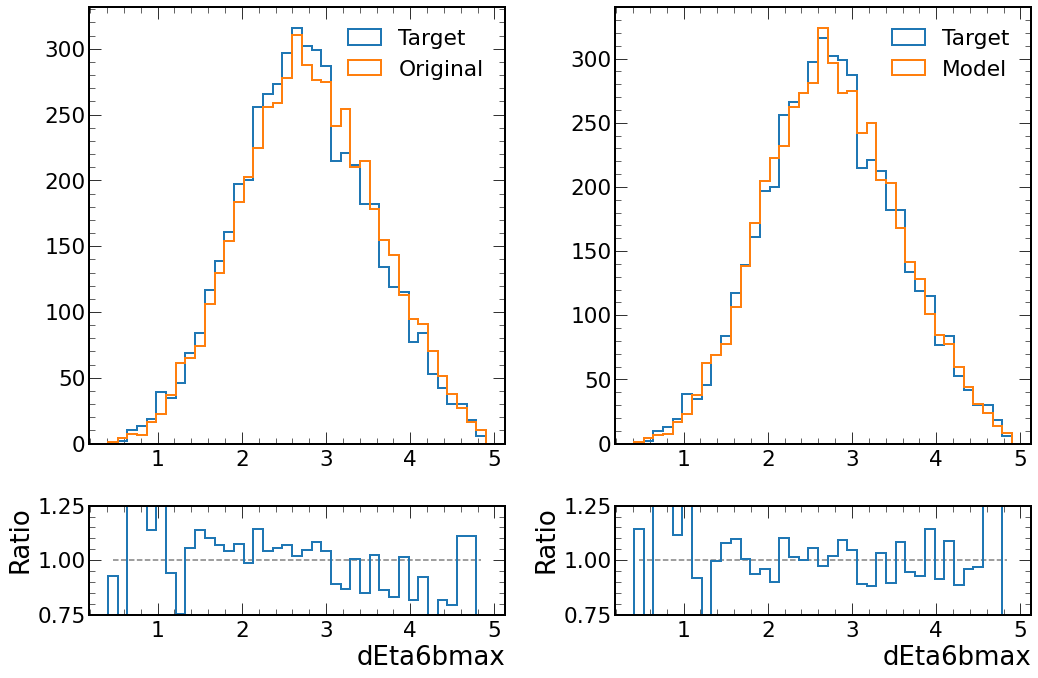

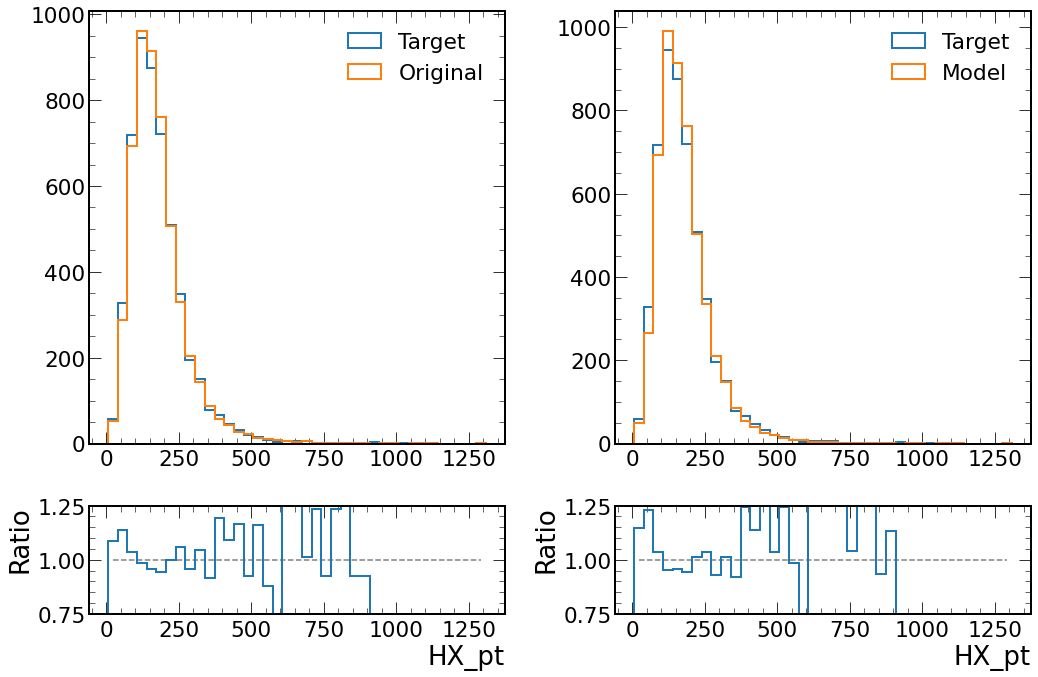

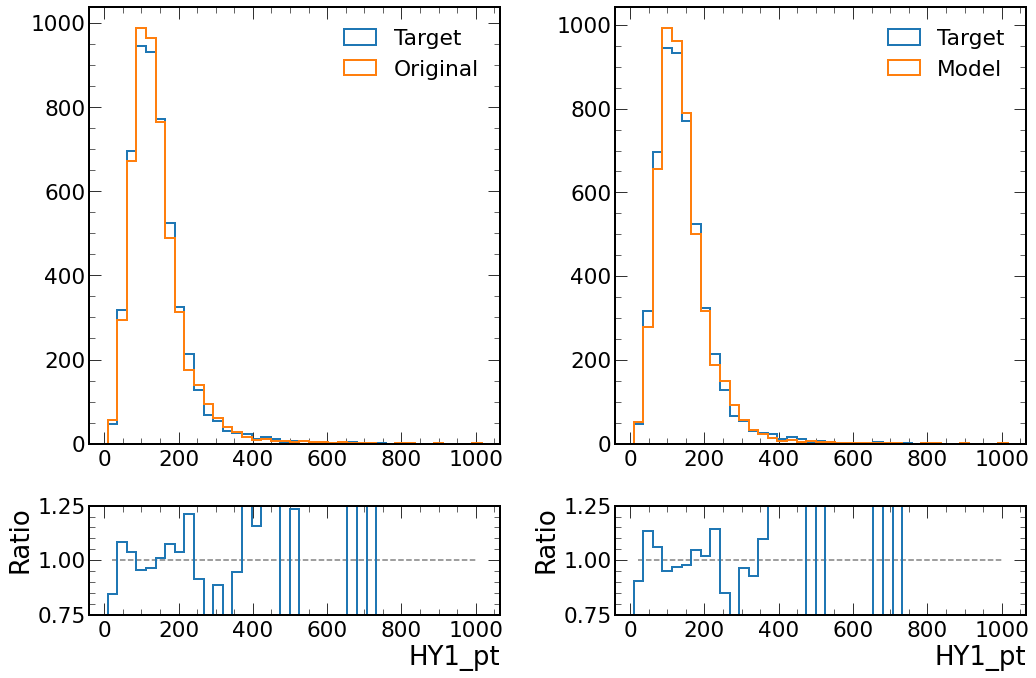

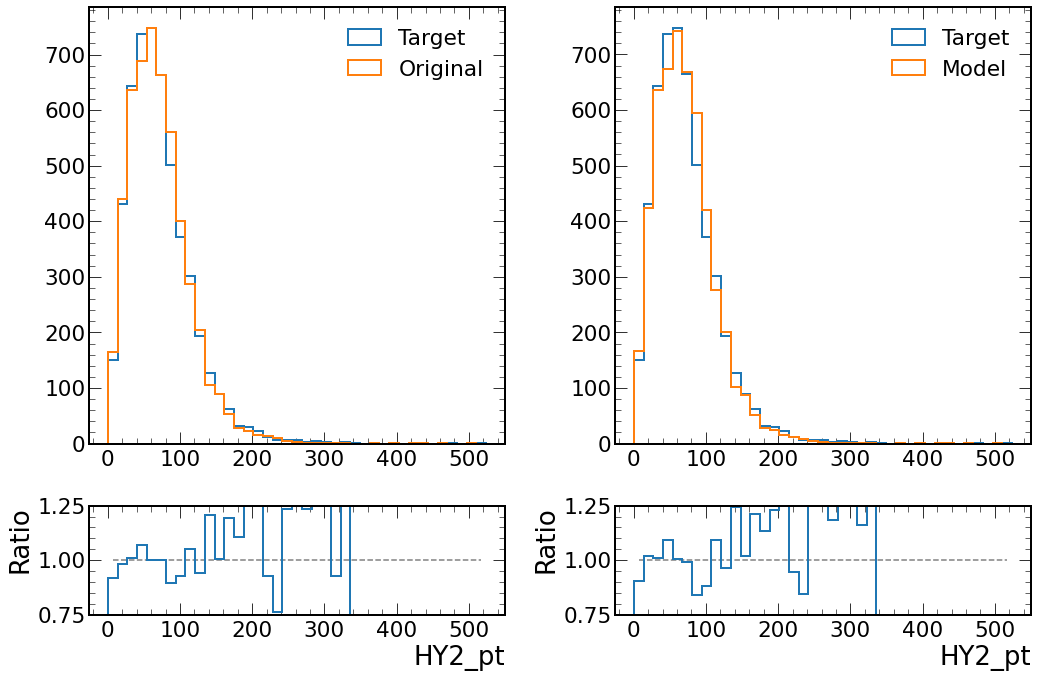

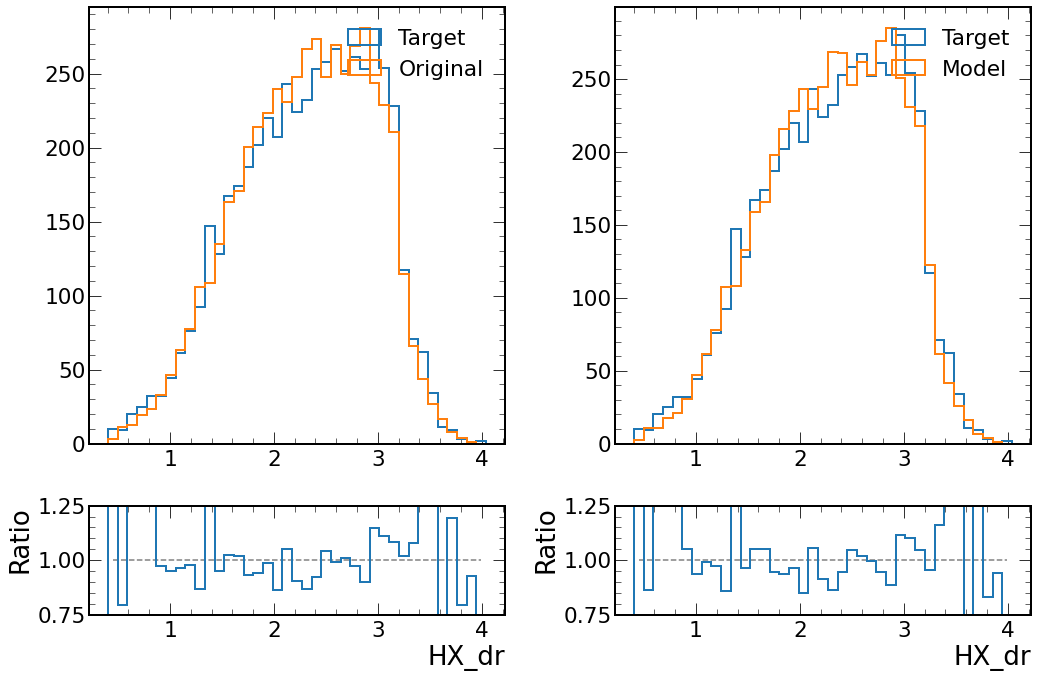

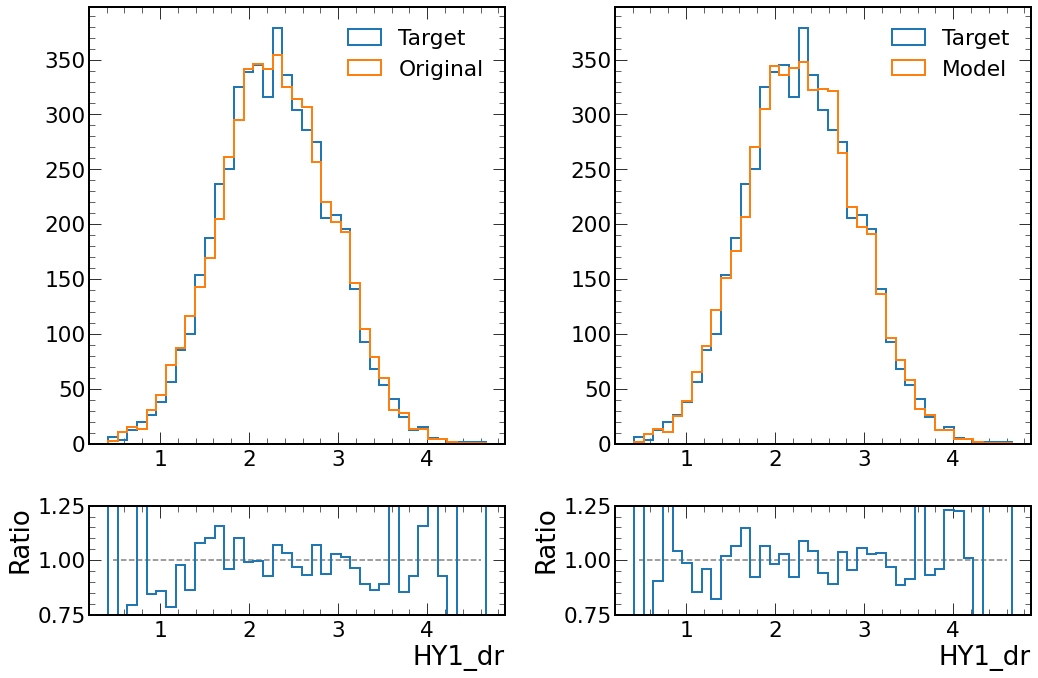

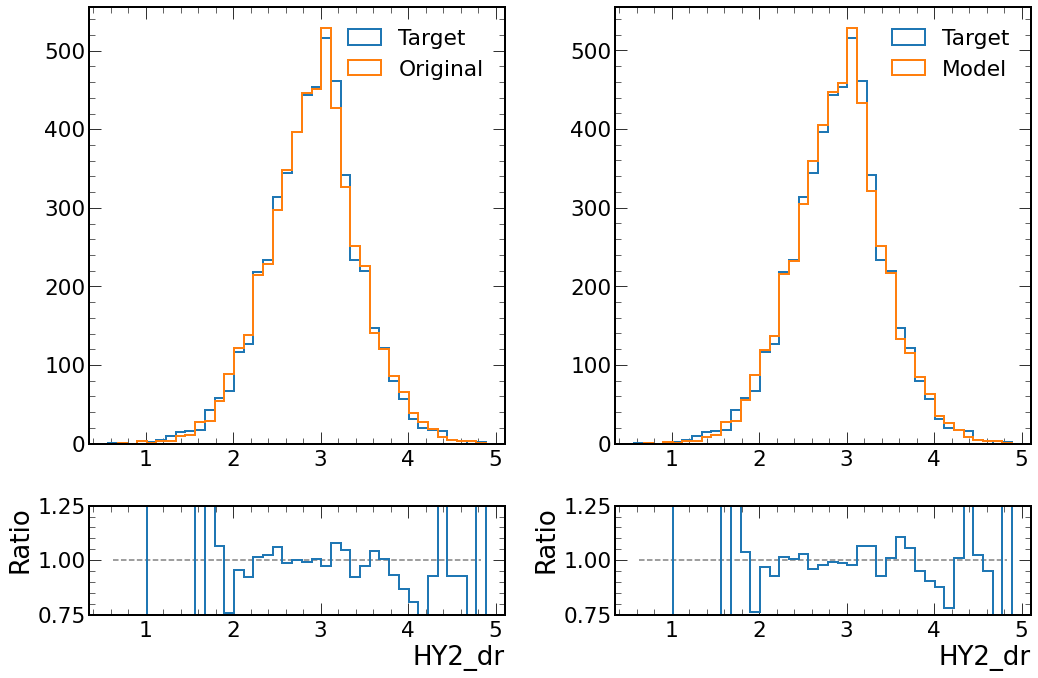

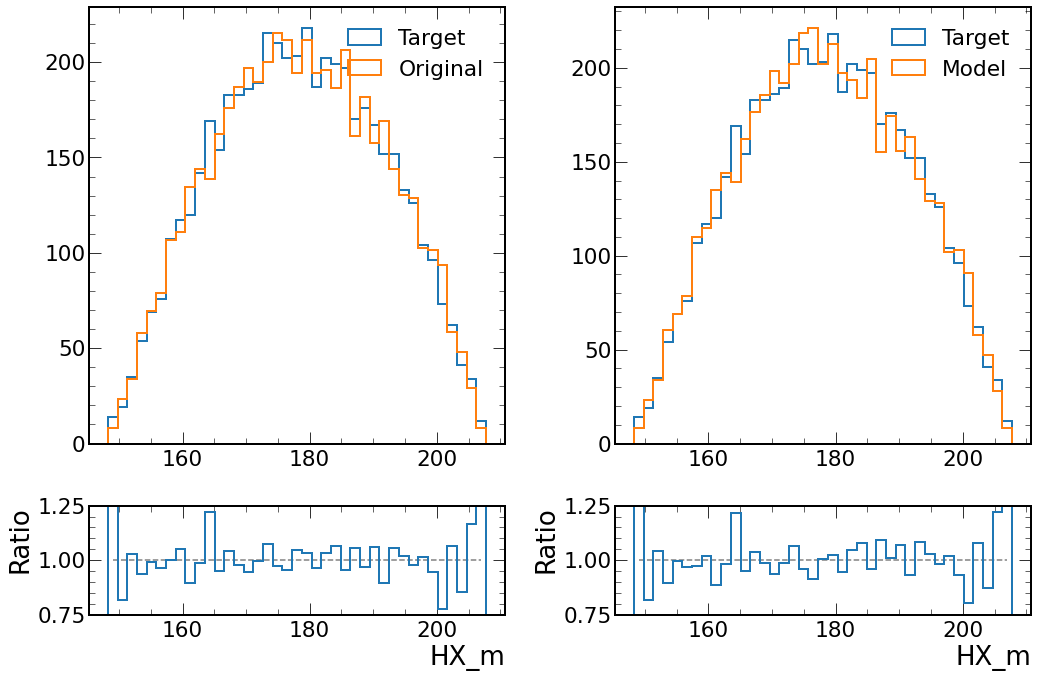

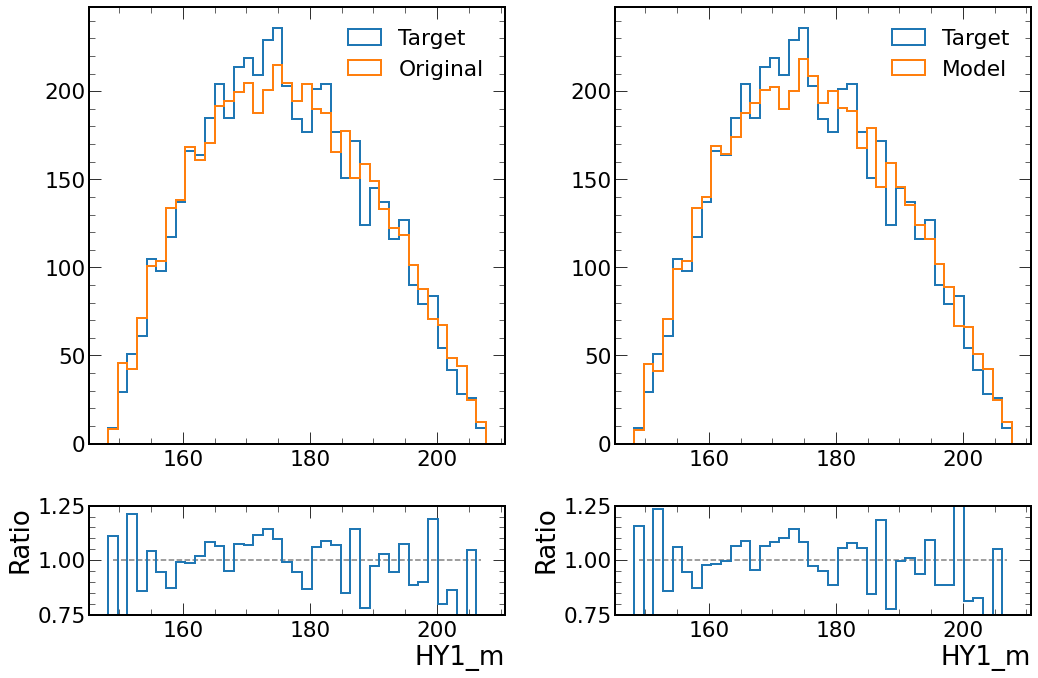

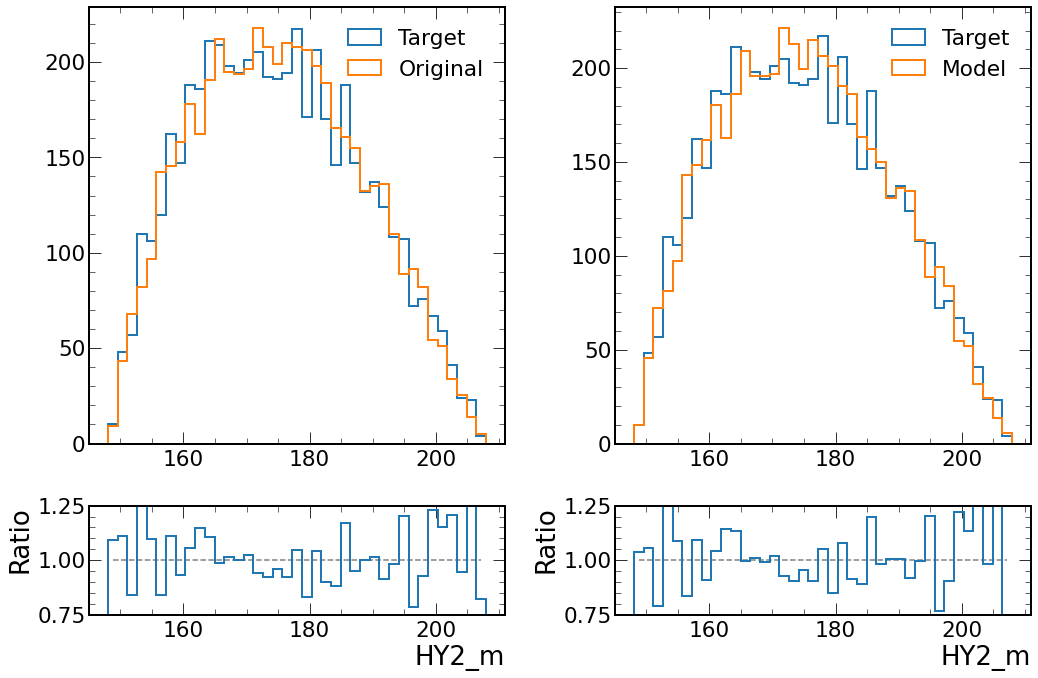

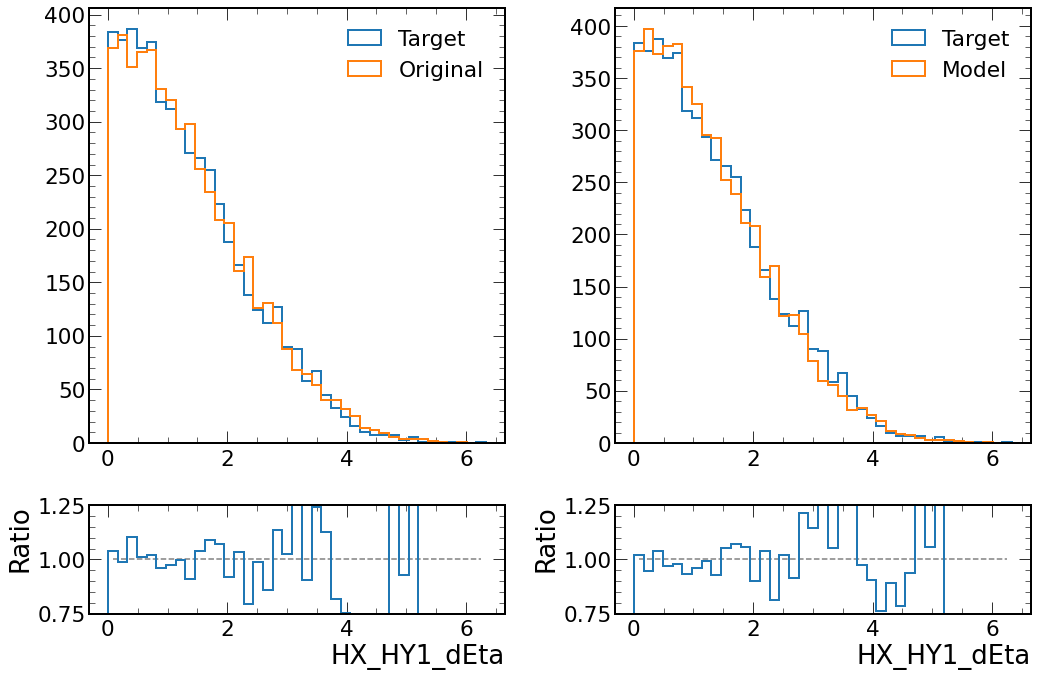

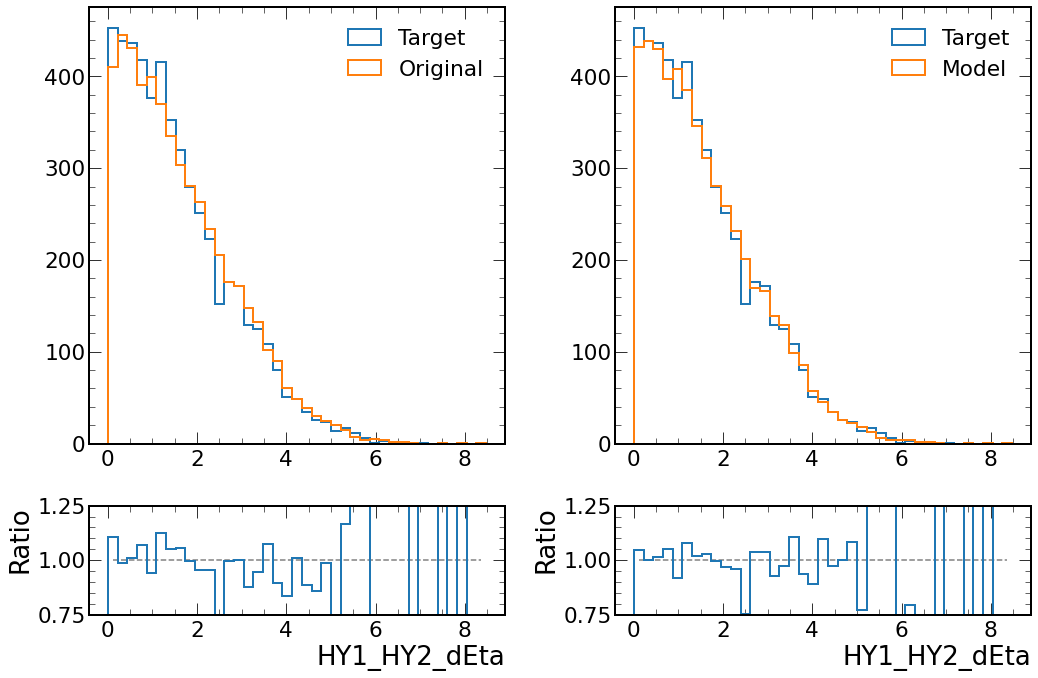

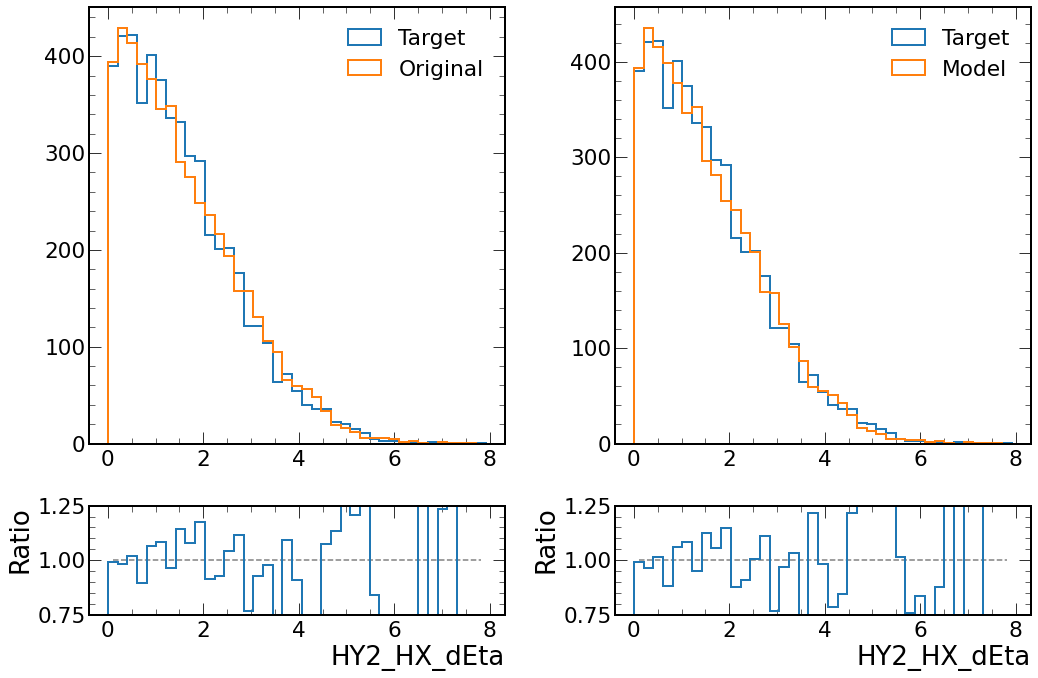

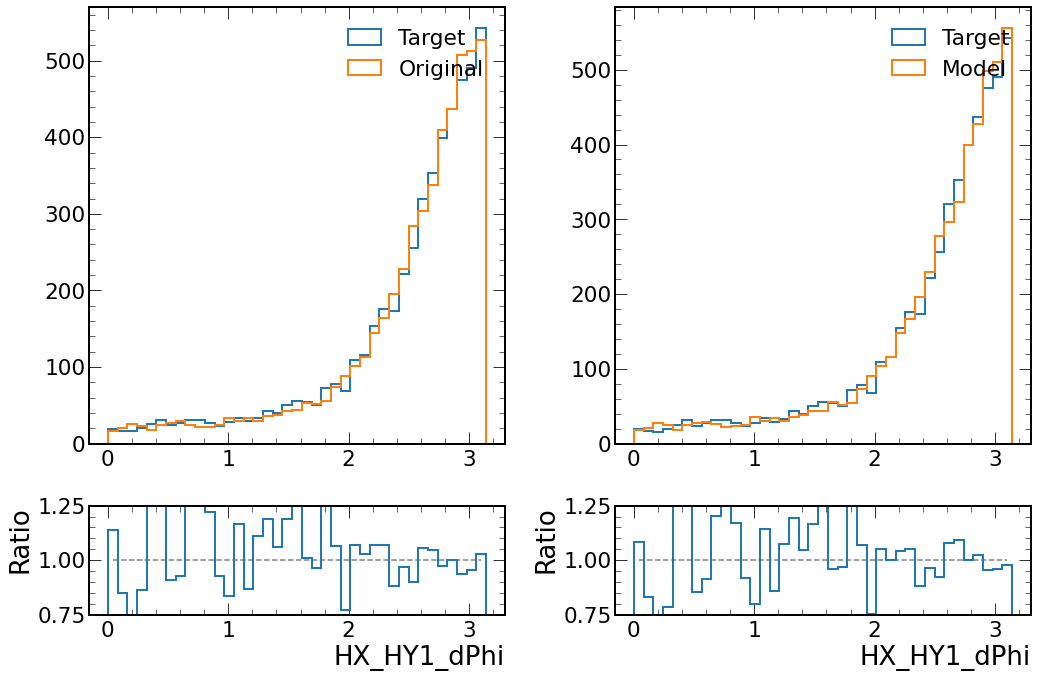

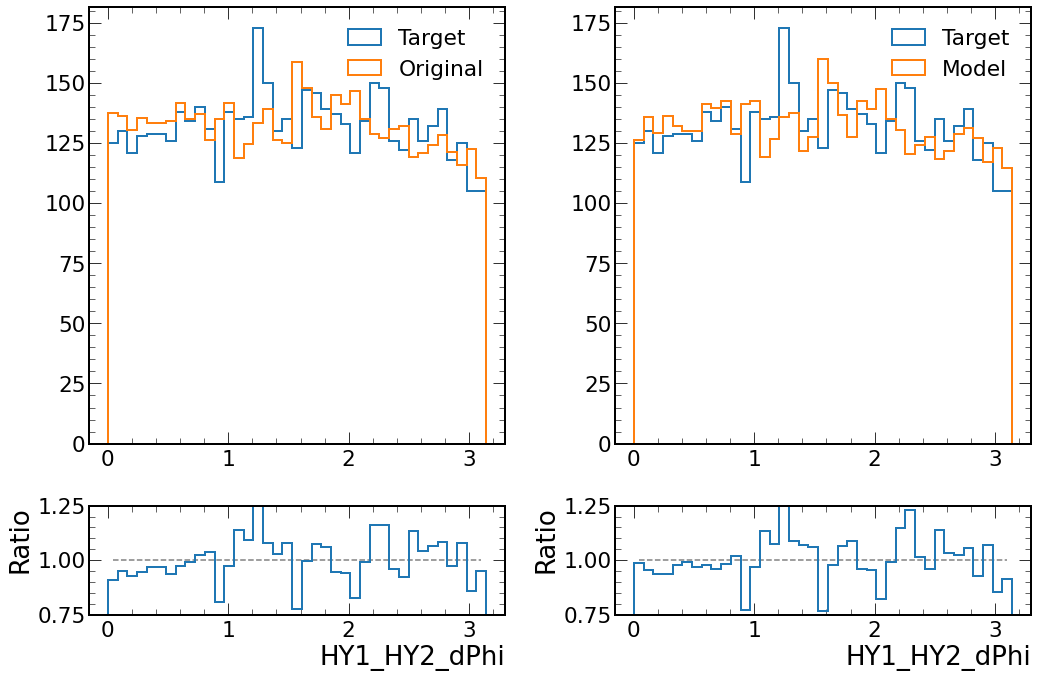

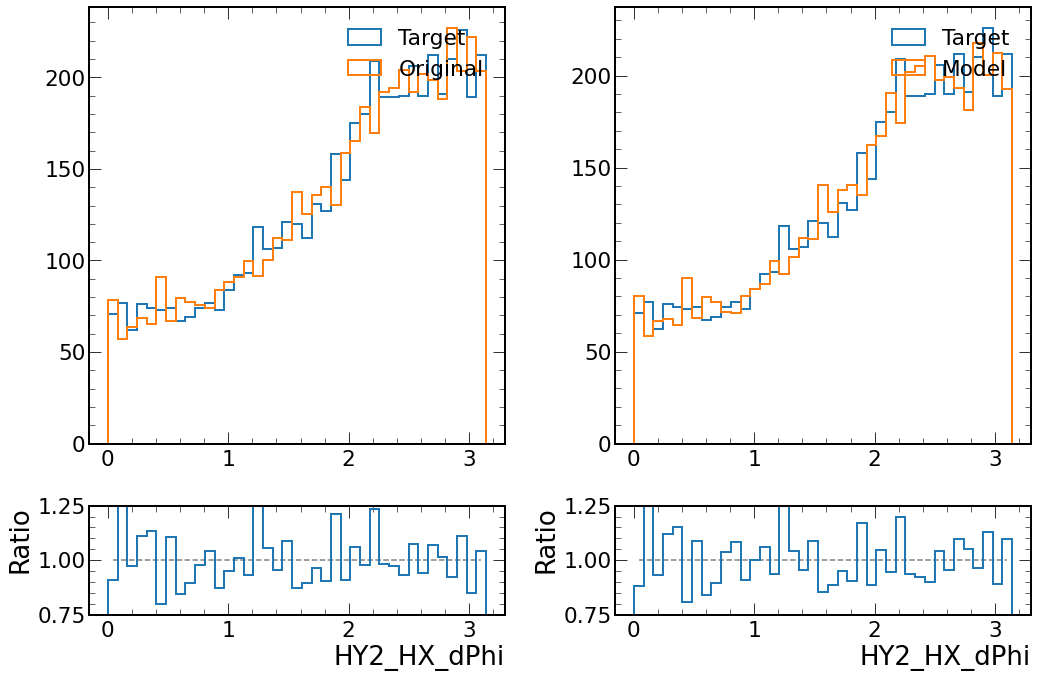

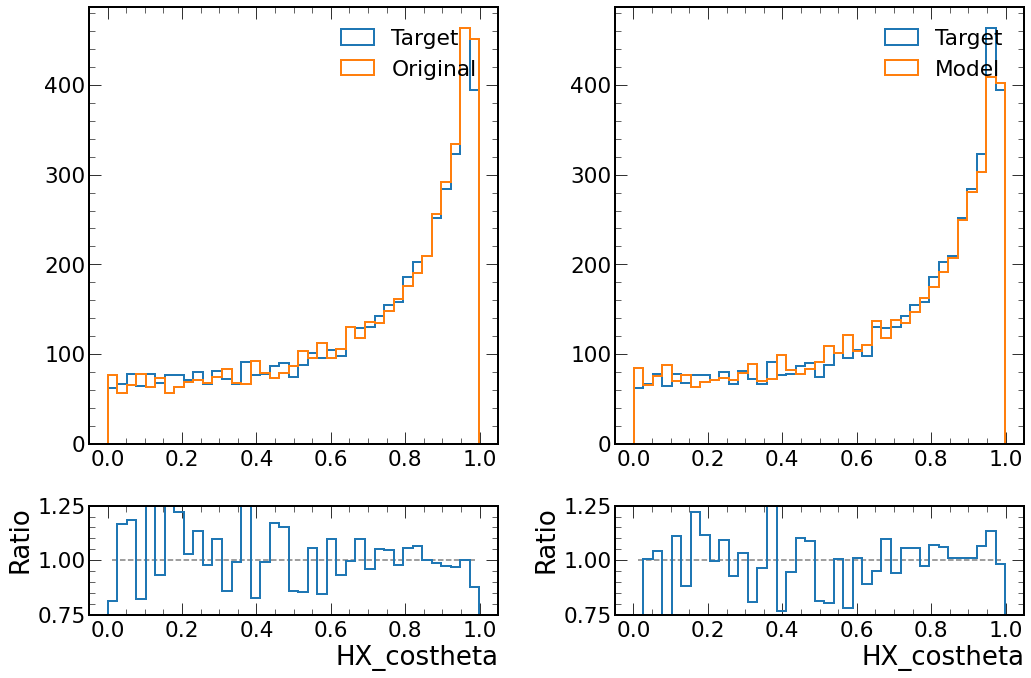

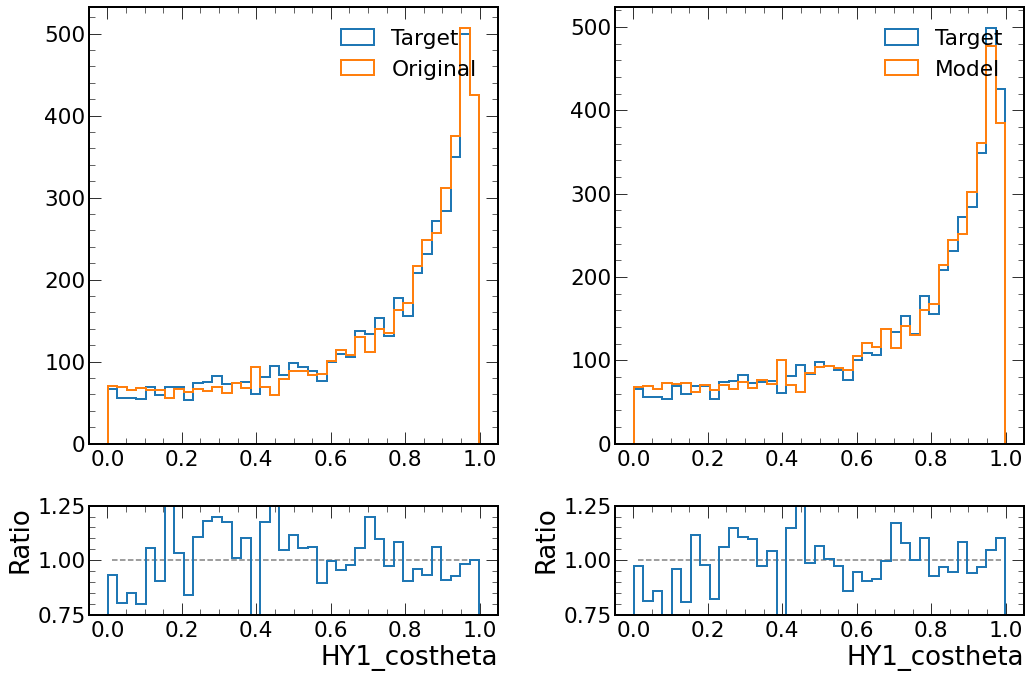

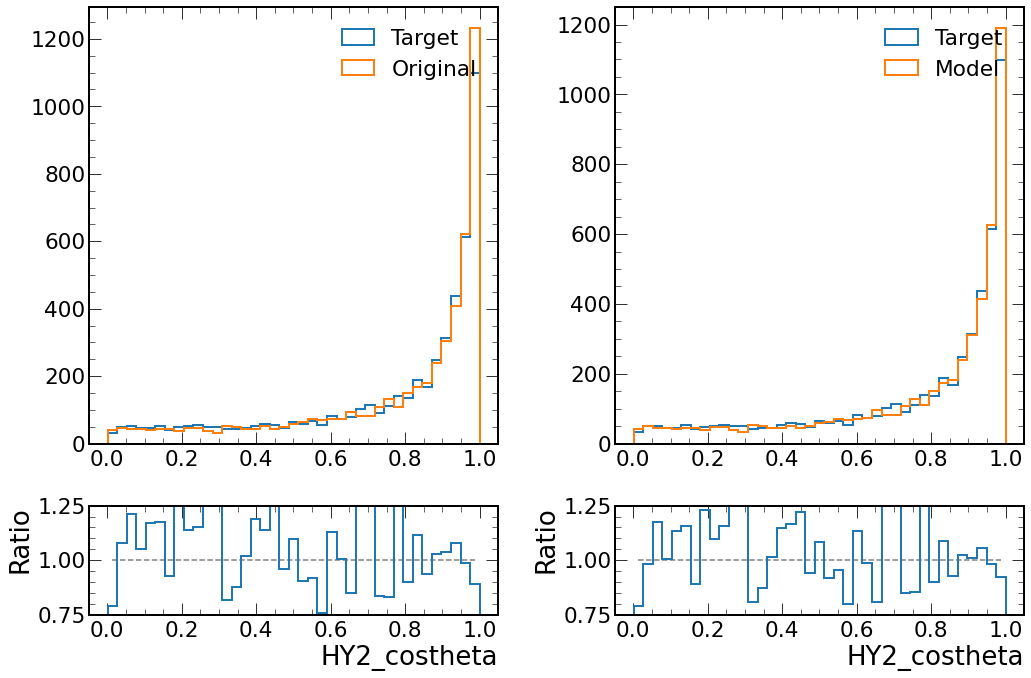

In [66]:
deltaD = []

for var in variables:
   d = plot_and_dist(var)
   deltaD.append(d)

In [68]:
ordered_d = np.argsort(np.array(deltaD))

In [70]:
deltaD_sort = np.array(deltaD)[ordered_d]
var_sort = np.array(variables)[ordered_d]

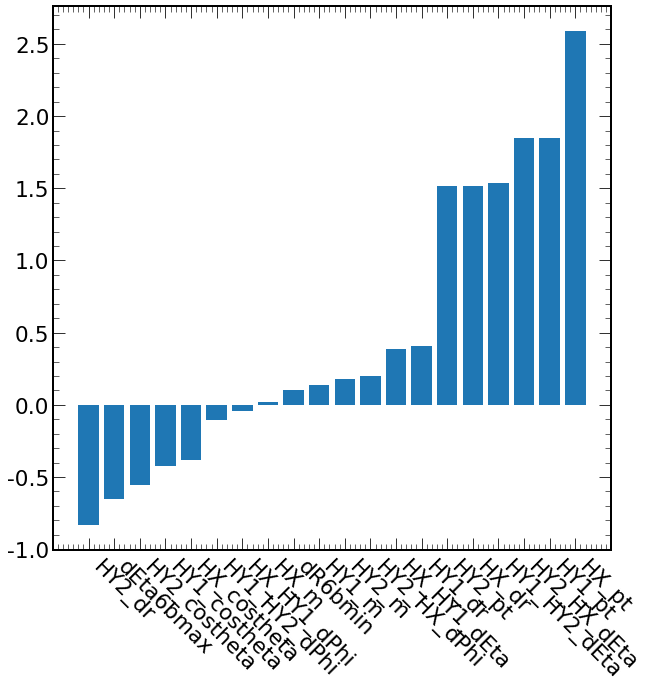

In [74]:
plt.bar(var_sort, deltaD_sort)
plt.xticks(ha='left', rotation=-45)
plt.show()

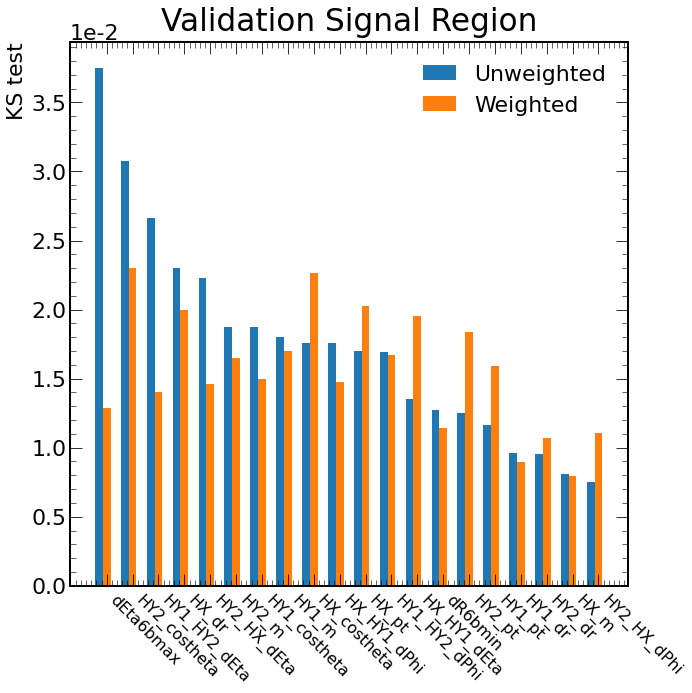

In [38]:
x = np.arange(len(datTree.V_CR_prob_w)) + 1

fig, ax = plt.subplots()
width = 0.3
fontsize = 22

ordered_mask = np.argsort(datTree.V_SR_kstest_pre)[::-1]
x_sorted = x[ordered_mask]
vars_sorted = np.array(variables)[ordered_mask]
V_SR_kstest_pre = datTree.V_SR_kstest_pre[ordered_mask]
V_SR_kstest = datTree.V_SR_kstest[ordered_mask]

ax.set_title("Validation Signal Region", y=1.01)
ax.bar(x-width, V_SR_kstest_pre, width=0.3, label='Unweighted')
ax.bar(x, V_SR_kstest, width=0.3, label='Weighted')
# ax.bar(x+0.25, datTree.A_CR_kstest, width=0.25, align='center', label='A_CR')

ax.yaxis.offsetText.set_fontsize(fontsize)
ax.tick_params(axis='both', labelsize=fontsize)
ax.set_xticks(x, vars_sorted, rotation=-45, ha='left', fontsize=16)
ax.set_ylabel('KS test', fontsize=fontsize)
ax.legend(fontsize=fontsize)

plt.show()

fig.savefig('plots/validation_ks.pdf', bbox_inches='tight')

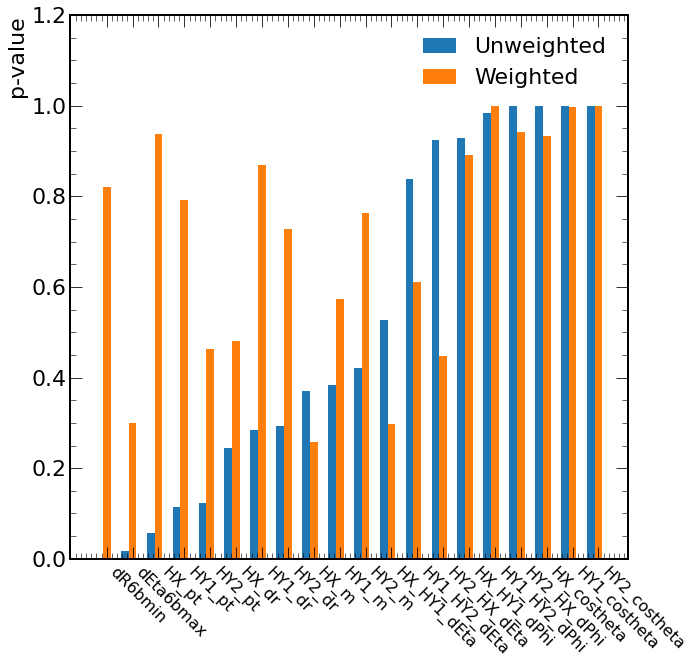

In [39]:
fig, ax = plt.subplots()
width = 0.3
fontsize = 22

ordered_mask = np.argsort(datTree.V_SR_prob_unw)
x_sorted = x[ordered_mask]
vars_sorted = np.array(variables)[ordered_mask]
V_SR_prob_unw = np.array(datTree.V_SR_prob_unw)[ordered_mask]
V_SR_prob_w   = np.array(datTree.V_SR_prob_w)[ordered_mask]

ax.bar(x-width, V_SR_prob_unw, width=0.3, label='Unweighted')
ax.bar(x, V_SR_prob_w, width=0.3, label='Weighted')
# ax.bar(x+0.25, datTree.A_CR_prob_w, width=0.25, align='center', label='A_CR')

ax.yaxis.offsetText.set_fontsize(fontsize)
ax.tick_params(axis='both', labelsize=fontsize)
ax.set_xticks(x, datTree.variables, rotation=-45, ha='left', fontsize=16)
ax.set_ylabel('p-value', fontsize=fontsize)
ax.legend(fontsize=fontsize)

ax.set_ylim(0, 1.2)
plt.show()

# fig.savefig('plots/validation_pvalues.pdf', bbox_inches='tight')

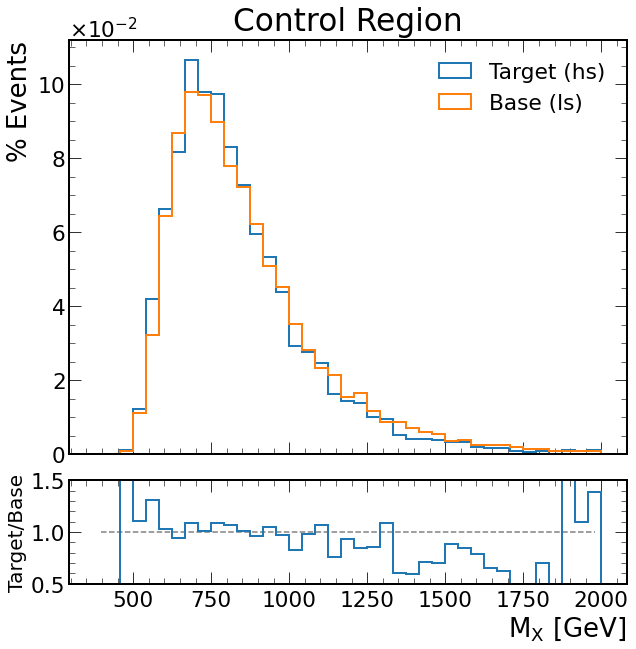

In [24]:
bins = np.linspace(375,2000,40)
x = (bins[:-1] + bins[1:]) / 2

fig, axs = plt.subplots(nrows=2, ncols=1, figsize=(10,10), sharex=True, gridspec_kw={'height_ratios':[4,1], 'hspace':0.1})

ax = axs[0]
ax.set_title('Control Region', pad=10)
n_target = Hist(datTree.np('X_m')[datTree.V_CRhs_mask], bins=bins, ax=ax, label='Target (hs)', density=1)
n_model  = Hist(datTree.np('X_m')[datTree.V_CRls_mask], bins=bins, ax=ax, label='Base (ls)', density=1)

# ax.set_title('Validation Region', pad=10)
# n_target = Hist(datTree.np('X_m')[datTree.V_SRhs_mask], bins=bins, ax=ax, label='Target (hs)', density=1)
# n_model  = Hist(datTree.np('X_m')[datTree.V_SRls_mask], bins=bins, ax=ax, label='Base (ls)', density=1)

ax.set_ylabel('% Events')
ax.legend()

ax = axs[1]
ax.plot(x, np.ones_like(x), '--', color='gray')
n_ratio = n_target / n_model
n_ratio = np.where(np.isnan(n_ratio), 0, n_ratio)
n_ratio = Hist(x, weights=n_ratio, bins=bins, ax=ax)


ax.set_xlabel(r'$M_\mathrm{X}$ [GeV]')
ax.set_ylabel('Target/Base', fontsize=20, loc='center')
ax.set_ylim(0.5, 1.5)


# ax = axs[0][1]
# ax.set_title('Validation Region', fontdict={'color':'slateblue'}, pad=10)
# n_target = Hist(datTree.np('X_m')[datTree.V_SRhs_mask], bins=bins, ax=ax, label='Target (hs)', density=1)
# n_model  = Hist(datTree.np('X_m')[datTree.V_SRls_mask], bins=bins, ax=ax, label='Base (ls)', density=1)

# ax = axs[1][1]
# ax.plot(x, np.ones_like(x), '--', color='gray')
# n_ratio = n_target / n_model
# n_ratio = np.where(np.isnan(n_ratio), 0, n_ratio)
# n_ratio = Hist(x, weights=n_ratio, bins=bins, ax=ax)

# for ax in axs[0][:]:
#    ax.set_ylabel('% Events')
   # ax.legend()

# for ax in axs[1][:]:
#    ax.set_xlabel(r'$M_\mathrm{X}$ [GeV]')
#    ax.set_ylabel('Target/Base', fontsize=20, loc='center')
#    ax.set_ylim(0.5, 1.5)

fig.savefig('plots/control_region.pdf', bbox_inches='tight')
# fig.savefig('plots/validation_region.pdf', bbox_inches='tight')

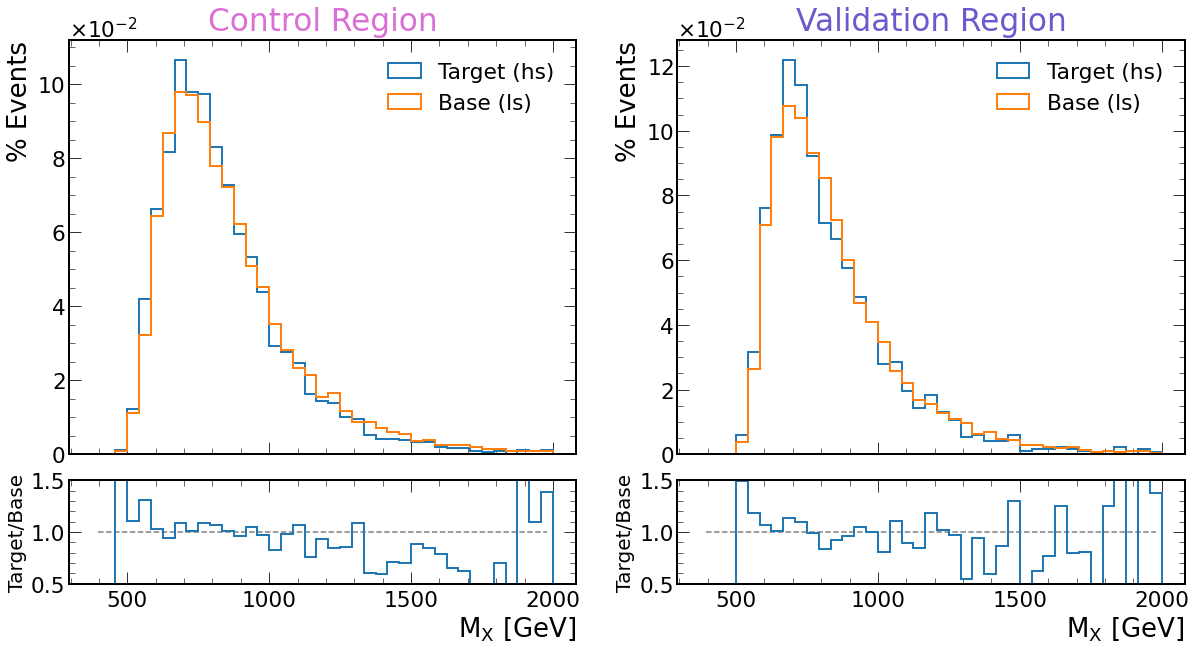

In [6]:
bins = np.linspace(375,2000,40)
x = (bins[:-1] + bins[1:]) / 2

fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(20,10), sharex=True, gridspec_kw={'height_ratios':[4,1], 'hspace':0.1})

ax = axs[0][0]
ax.set_title('Control Region', fontdict={'color':'orchid'}, pad=10)
n_target = Hist(datTree.np('X_m')[datTree.V_CRhs_mask], bins=bins, ax=ax, label='Target (hs)', density=1)
n_model  = Hist(datTree.np('X_m')[datTree.V_CRls_mask], bins=bins, ax=ax, label='Base (ls)', density=1)

ax = axs[1][0]
ax.plot(x, np.ones_like(x), '--', color='gray')
n_ratio = n_target / n_model
n_ratio = np.where(np.isnan(n_ratio), 0, n_ratio)
n_ratio = Hist(x, weights=n_ratio, bins=bins, ax=ax)

ax = axs[0][1]
ax.set_title('Validation Region', fontdict={'color':'slateblue'}, pad=10)
n_target = Hist(datTree.np('X_m')[datTree.V_SRhs_mask], bins=bins, ax=ax, label='Target (hs)', density=1)
n_model  = Hist(datTree.np('X_m')[datTree.V_SRls_mask], bins=bins, ax=ax, label='Base (ls)', density=1)

ax = axs[1][1]
ax.plot(x, np.ones_like(x), '--', color='gray')
n_ratio = n_target / n_model
n_ratio = np.where(np.isnan(n_ratio), 0, n_ratio)
n_ratio = Hist(x, weights=n_ratio, bins=bins, ax=ax)

for ax in axs[0][:]:
   ax.set_ylabel('% Events')
   ax.legend()

for ax in axs[1][:]:
   ax.set_xlabel(r'$M_\mathrm{X}$ [GeV]')
   ax.set_ylabel('Target/Base', fontsize=20, loc='center')
   ax.set_ylim(0.5, 1.5)

# fig.savefig('plots/unweighted.pdf', bbox_inches='tight')

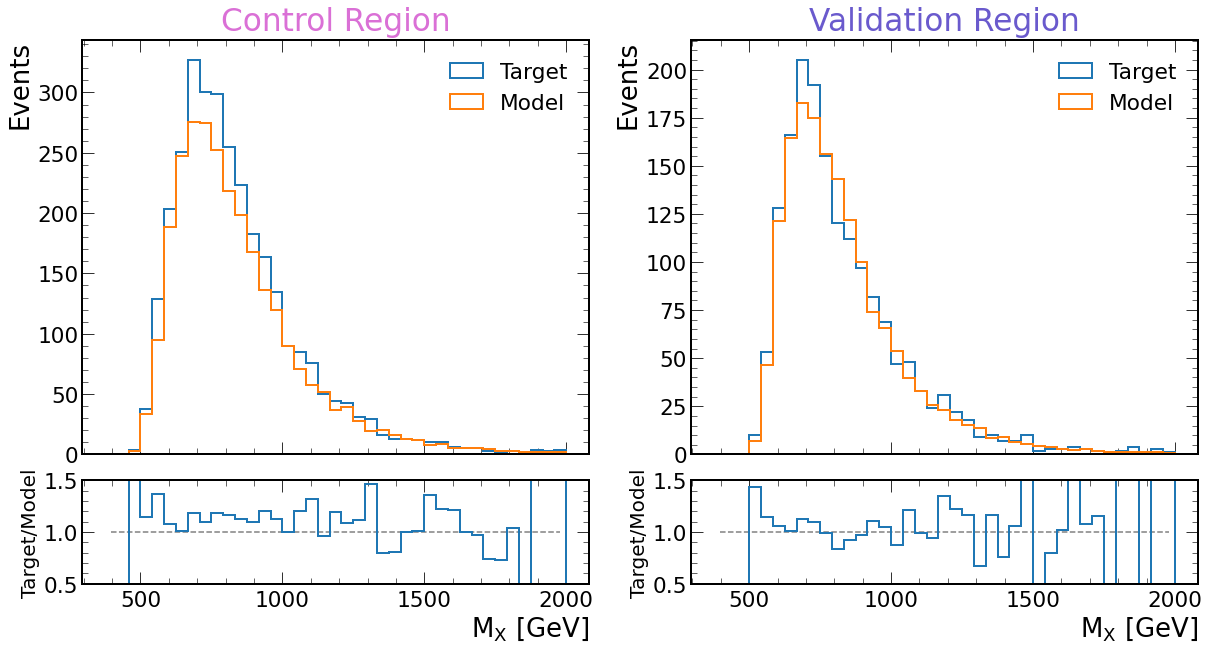

In [107]:
bins = np.linspace(375,2000,40)
x = (bins[:-1] + bins[1:]) / 2

fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(20,10), sharex=True, gridspec_kw={'height_ratios':[4,1], 'hspace':0.1})

ax = axs[0][0]
ax.set_title('Control Region', fontdict={'color':'orchid'}, pad=10)
n_target = Hist(datTree.np('X_m')[datTree.V_CRhs_mask], bins=bins, ax=ax, label='Target')
n_model  = Hist(datTree.np('X_m')[datTree.V_CRls_mask], bins=bins, weights=datTree.CR_weights, ax=ax, label='Model')

ax = axs[1][0]
ax.plot(x, np.ones_like(x), '--', color='gray')
n_ratio = n_target / n_model
n_ratio = np.where(np.isnan(n_ratio), 0, n_ratio)
n_ratio = Hist(x, weights=n_ratio, bins=bins, ax=ax)

ax = axs[0][1]
ax.set_title('Validation Region', fontdict={'color':'slateblue'}, pad=10)
n_target = Hist(datTree.np('X_m')[datTree.V_SRhs_mask], bins=bins, ax=ax, label='Target')
n_model  = Hist(datTree.np('X_m')[datTree.V_SRls_mask], bins=bins, weights=datTree.VR_weights, ax=ax, label='Model')

ax = axs[1][1]
ax.plot(x, np.ones_like(x), '--', color='gray')
n_ratio = n_target / n_model
n_ratio = np.where(np.isnan(n_ratio), 0, n_ratio)
n_ratio = Hist(x, weights=n_ratio, bins=bins, ax=ax)

for ax in axs[0][:]:
   ax.set_ylabel('Events')
   ax.legend()

for ax in axs[1][:]:
   ax.set_xlabel(r'$M_\mathrm{X}$ [GeV]')
   ax.set_ylabel(r'Target/Model', fontsize=20, loc='center')
   # ax.set_ylabel(r'$\frac{\mathrm{Target}}{\mathrm{Model}}$')
   ax.set_ylim(0.5, 1.5)

fig.savefig('plots/weighted_v_unweighted_raw.pdf', bbox_inches='tight')

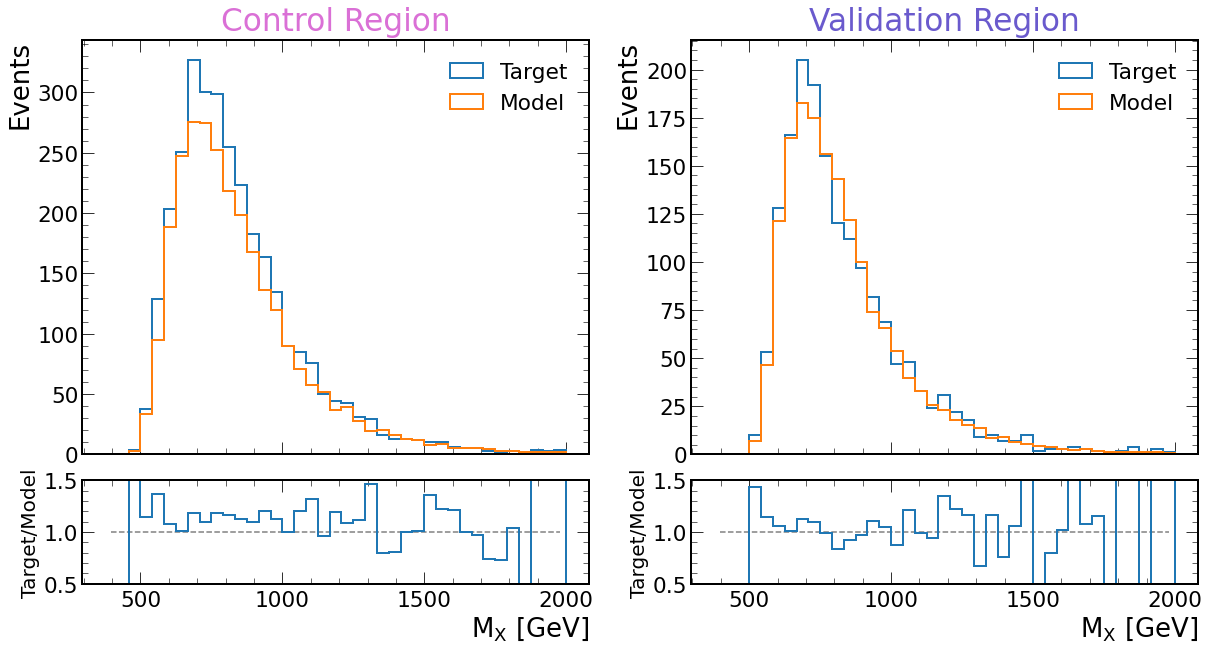

In [ ]:
bins = np.linspace(375,2000,40)
x = (bins[:-1] + bins[1:]) / 2

fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(20,10), sharex=True, gridspec_kw={'height_ratios':[4,1], 'hspace':0.1})

ax = axs[0][0]
ax.set_title('Control Region', fontdict={'color':'orchid'}, pad=10)
n_target = Hist(datTree.np('X_m')[datTree.V_CRhs_mask], bins=bins, ax=ax, label='Target')
n_model  = Hist(datTree.np('X_m')[datTree.V_CRls_mask], bins=bins, weights=datTree.CR_weights, ax=ax, label='Model')

ax = axs[1][0]
ax.plot(x, np.ones_like(x), '--', color='gray')
n_ratio = n_target / n_model
n_ratio = np.where(np.isnan(n_ratio), 0, n_ratio)
n_ratio = Hist(x, weights=n_ratio, bins=bins, ax=ax)

ax = axs[0][1]
ax.set_title('Validation Region', fontdict={'color':'slateblue'}, pad=10)
n_target = Hist(datTree.np('X_m')[datTree.V_SRhs_mask], bins=bins, ax=ax, label='Target')
n_model  = Hist(datTree.np('X_m')[datTree.V_SRls_mask], bins=bins, weights=datTree.VR_weights, ax=ax, label='Model')

ax = axs[1][1]
ax.plot(x, np.ones_like(x), '--', color='gray')
n_ratio = n_target / n_model
n_ratio = np.where(np.isnan(n_ratio), 0, n_ratio)
n_ratio = Hist(x, weights=n_ratio, bins=bins, ax=ax)

for ax in axs[0][:]:
   ax.set_ylabel('Events')
   ax.legend()

for ax in axs[1][:]:
   ax.set_xlabel(r'$M_\mathrm{X}$ [GeV]')
   ax.set_ylabel(r'Target/Model', fontsize=20, loc='center')
   # ax.set_ylabel(r'$\frac{\mathrm{Target}}{\mathrm{Model}}$')
   ax.set_ylim(0.5, 1.5)

fig.savefig('plots/weighted_v_unweighted_raw.pdf', bbox_inches='tight')

CONTROL
Constant 10.328837259280217
Model 10.01885310187916
VALIDATION
Constant 13.284028263591686
Reweighted Bins nan
Model 16.54279967208203


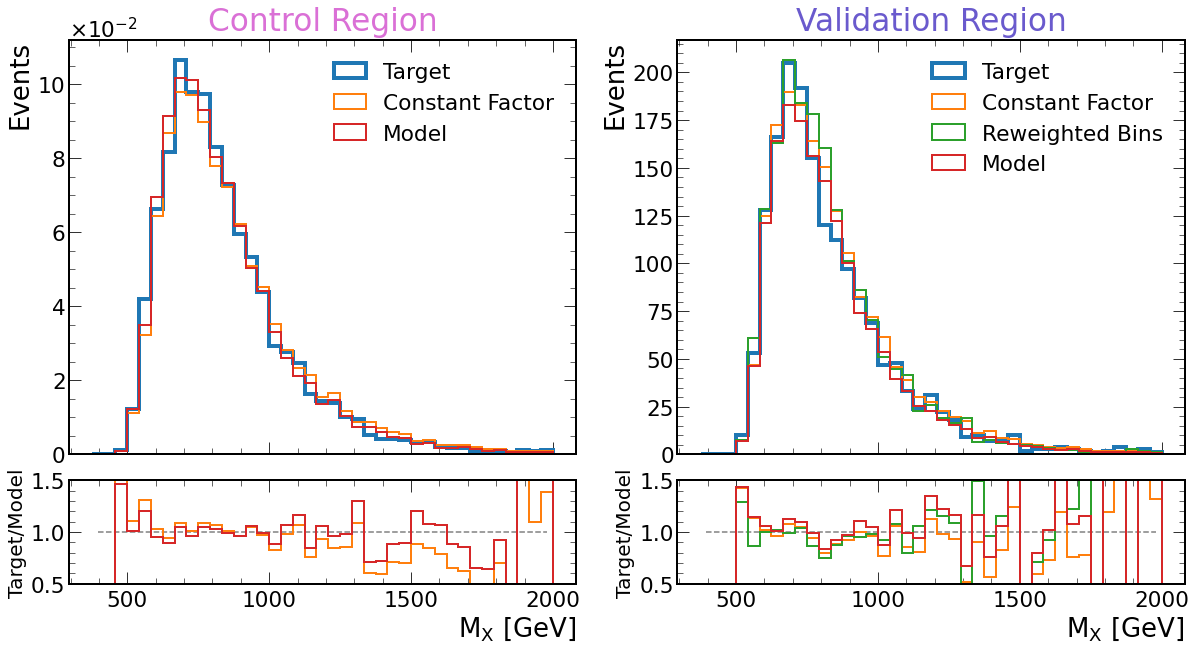

In [11]:
bins = np.linspace(375,2000,40)
x = (bins[:-1] + bins[1:]) / 2

fig, axs = plt.subplots(nrows=2, ncols=2, sharex=True, gridspec_kw={'height_ratios':[4,1], 'hspace':0.1}, figsize=(20,10))

n_target, _     = np.histogram(datTree.np('X_m')[datTree.V_CRhs_mask], bins=bins)
n_unweighted, _ = np.histogram(datTree.np('X_m')[datTree.V_CRls_mask], bins=bins)
n_weighted, _   = np.histogram(datTree.np('X_m')[datTree.V_CRls_mask], weights=datTree.CR_weights, bins=bins)
n_original, _   = np.histogram(datTree.np('X_m')[datTree.V_SRls_mask], bins=bins)

bin_norms = n_target/n_unweighted
bin_norms = np.where(np.isnan(bin_norms), 0, bin_norms)
norm_unweighted = n_original * bin_norms
norm_unweighted = np.where(np.isnan(norm_unweighted), 0, norm_unweighted)

norm_tf = n_target.sum() / n_unweighted.sum()
tf_weighted = n_original * norm_tf
norm_tf = norm_tf * n_unweighted

bin_norms = n_target/n_weighted
bin_norms = np.where(np.isnan(bin_norms), 0, bin_norms)
norm_weighted = n_weighted * bin_norms
norm_weighted = np.where(np.isnan(norm_weighted), 0, norm_weighted)

ax = axs[0][0]
ax.set_title('Control Region', pad=10, fontdict={'color':'orchid'})
n_target = Hist(datTree.np('X_m')[datTree.V_CRhs_mask], bins=bins, ax=ax, label='Target', density=1, linewidth=4)
n_tf_reweighted = Hist(x, weights=norm_tf, bins=bins, ax=ax, label='Constant Factor', density=1)
n_model  = Hist(datTree.np('X_m')[datTree.V_CRls_mask], bins=bins, weights=datTree.CR_weights, ax=ax, label='Model', density=1, color='C3')
# n_reweighted = Hist(x, weights=bin_norms, bins=bins, ax=ax, label='Reweighted Bins', density=1)
# n = Hist(datTree.np('X_m')[datTree.V_SRls_mask], bins=bins, weights=datTree.VR_weights, ax=ax, label='BDT Reweighted')
# n = Hist(x, weights=norm_weighted, bins=bins, ax=ax, label='BDT & Bin Reweighted')

ax = axs[1][0]
print("CONTROL")
ax.plot(x, np.ones_like(x), '--', color='gray')
n_ratio = n_target / n_tf_reweighted
n_ratio = np.where(np.isnan(n_ratio), 0, n_ratio)
n_ratio = Hist(x, weights=n_ratio, bins=bins, ax=ax, color='C1')
print("Constant", sum(abs(n_ratio-1)))
n_ratio = n_target / n_model
n_ratio = np.where(np.isnan(n_ratio), 0, n_ratio)
n_ratio = Hist(x, weights=n_ratio, bins=bins, ax=ax, color='C3')
print("Model", sum(abs(n_ratio-1)))

ax = axs[0][1]
ax.set_title('Validation Region', pad=10, fontdict={'color':'slateblue'})
n_target = Hist(datTree.np('X_m')[datTree.V_SRhs_mask], bins=bins, ax=ax, label='Target', linewidth=4)
n_tf_reweighted = Hist(x, weights=tf_weighted, bins=bins, ax=ax, label='Constant Factor')
n_reweighted = Hist(x, weights=norm_unweighted, bins=bins, ax=ax, label='Reweighted Bins')
n_model  = Hist(datTree.np('X_m')[datTree.V_SRls_mask], bins=bins, weights=datTree.VR_weights, ax=ax, label='Model', color='C3')
# n = Hist(datTree.np('X_m')[datTree.V_SRls_mask], bins=bins, weights=datTree.VR_weights, ax=ax, label='BDT Reweighted')
# n = Hist(x, weights=norm_weighted, bins=bins, ax=ax, label='BDT & Bin Reweighted')

ax = axs[1][1]
print("VALIDATION")
ax.plot(x, np.ones_like(x), '--', color='gray')
n_ratio = n_target / n_tf_reweighted
n_ratio = np.where(np.isnan(n_ratio), 0, n_ratio)
n_ratio = Hist(x, weights=n_ratio, bins=bins, ax=ax, color='C1')
print("Constant", sum(abs(n_ratio-1)))

n_ratio = n_target / n_reweighted
n_ratio = np.where(np.isnan(n_ratio), 0, n_ratio)
n_ratio = Hist(x, weights=n_ratio, bins=bins, ax=ax, color='C2')
print("Reweighted Bins", sum(abs(n_ratio-1)))

n_ratio = n_target / n_model
n_ratio = np.where(np.isnan(n_ratio), 0, n_ratio)
n_ratio = Hist(x, weights=n_ratio, bins=bins, ax=ax, color='C3')
print("Model", sum(abs(n_ratio-1)))

for ax in axs[0][:]:
   ax.set_ylabel('Events')
   ax.legend()

for ax in axs[1][:]:
   ax.set_xlabel(r'$M_\mathrm{X}$ [GeV]')
   ax.set_ylabel(r'Target/Model', fontsize=20, loc='center')
   ax.set_ylim(0.5, 1.5)

fig.savefig('plots/constant_weight.pdf', bbox_inches='tight')

10.01885310187915
15.918341424904956


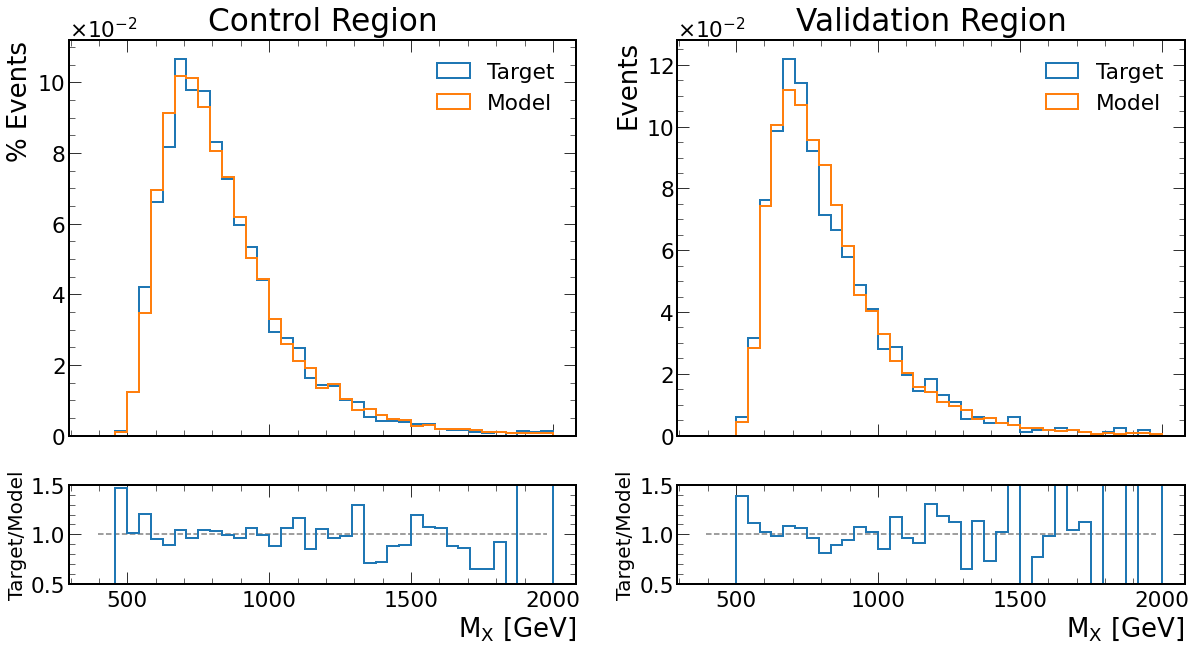

In [140]:
fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(20,10), gridspec_kw={'height_ratios':[4,1]}, sharex=True)

data = [datTree.get('X_m')[datTree.V_CRhs_mask], datTree.np('X_m')[datTree.V_CRls_mask]]
ax1 = Ratio(data, bins, ['Target', 'Model'], xlabel=r'$M_\mathrm{X}$ [GeV]', weights2=datTree.CR_weights, density=1, axs=axs[:,0])
data = [datTree.get('X_m')[datTree.V_SRhs_mask], datTree.np('X_m')[datTree.V_SRls_mask]]
ax2 = Ratio(data, bins, ['Target', 'Model'], xlabel=r'$M_\mathrm{X}$ [GeV]', weights2=datTree.VR_weights, density=1, axs=axs[:,1])

ax1[0].set_ylabel('% Events')
ax1[0].set_title('Control Region', pad=10)
ax2[0].set_ylabel('Events')
ax2[0].set_title('Validation Region', pad=10)

for ax in axs[1,:]:
   ax.set_ylabel(r'Target/Model', fontsize=20, loc='center')
   ax.set_ylim(0.5, 1.5)

fig.savefig('plots/model_CR_v_VR.pdf')

In [14]:
region = 'CR'

if region == 'CR':
   title = 'Control Region'
   hs_mask = datTree.V_CRhs_mask
   ls_mask = datTree.V_CRls_mask
elif region == 'VR':
   title = 'Validation Region'
   hs_mask = datTree.V_SRhs_mask
   ls_mask = datTree.V_SRls_mask

In [15]:
print("CR total = ", sum(datTree.A_CRhs_mask) + sum(datTree.A_CRls_mask))
print("CR low   = ", sum(datTree.A_CRls_mask))
print("CR high  = ", sum(datTree.A_CRhs_mask))

CR total =  40673
CR low   =  35252
CR high  =  5421


In [16]:
def get_prob(ls_mask, hs_mask, weights):
   target = abs(datTree.get(var, 'np'))[hs_mask]
   original = abs(datTree.get(var, 'np'))[ls_mask]

   if min(target) < min(original): b_min = min(target)
   else: b_min = min(original)
   if max(target) > max(original): b_max = max(target)
   else: b_max = max(original)
   if b_max >= 1000: b_max = b_max / 2

   bins = np.linspace(b_min,b_max,20)

   n_target    , _ = np.histogram(target, bins=bins)
   n_unweighted, _ = np.histogram(original, bins=bins)
   n_weighted  , _ = np.histogram(original, bins=bins, weights=weights)

   try: del h_target, h_weighted, h_unweighted
   except: pass

   h_target = ROOT.TH1D(var+"1",var+"1",len(n_target),array('d',list(bins)))
   h_weighted = ROOT.TH1D(var+"2",var+"2",len(n_weighted),array('d',list(bins)))
   h_unweighted = ROOT.TH1D(var+"3",var+"3",len(n_unweighted),array('d',list(bins)))
   for i,(n_t, n_w, n_un) in enumerate(zip(n_target, n_weighted, n_unweighted)):
      h_target.SetBinContent(i+1, n_t)
      h_weighted.SetBinContent(i+1, n_w)
      h_unweighted.SetBinContent(i+1, n_un)

   p_w = h_target.KolmogorovTest(h_weighted)
   p_unw = h_target.KolmogorovTest(h_unweighted)

   return p_w, p_unw

In [35]:
CR_p_w, CR_p_unw = [], []
# CR_t_w, CR_t_unw = [], []
VR_p_w, VR_p_unw = [], []
# VR_t_w, VR_t_unw = [], []

if 'X_m' not in variables: variables.append('X_m')
for var in variables:
   CR_w, CR_un = get_prob(datTree.V_CRls_mask, datTree.V_CRhs_mask, datTree.CR_weights)
   VR_w, VR_un = get_prob(datTree.V_SRls_mask, datTree.V_SRhs_mask, datTree.VR_weights)

   CR_p_w.append(CR_w)
   CR_p_unw.append(CR_un)
   VR_p_w.append(VR_w)
   VR_p_unw.append(VR_un)

<ipython-input-45-903221485935>:22: UserWarning: FixedFormatter should only be used together with FixedLocator
  axs[1][0].set_xticklabels(variables, ha='left', rotation=-45, fontsize=14)
<ipython-input-45-903221485935>:23: UserWarning: FixedFormatter should only be used together with FixedLocator
  axs[1][1].set_xticklabels(variables, ha='left', rotation=-45, fontsize=14)


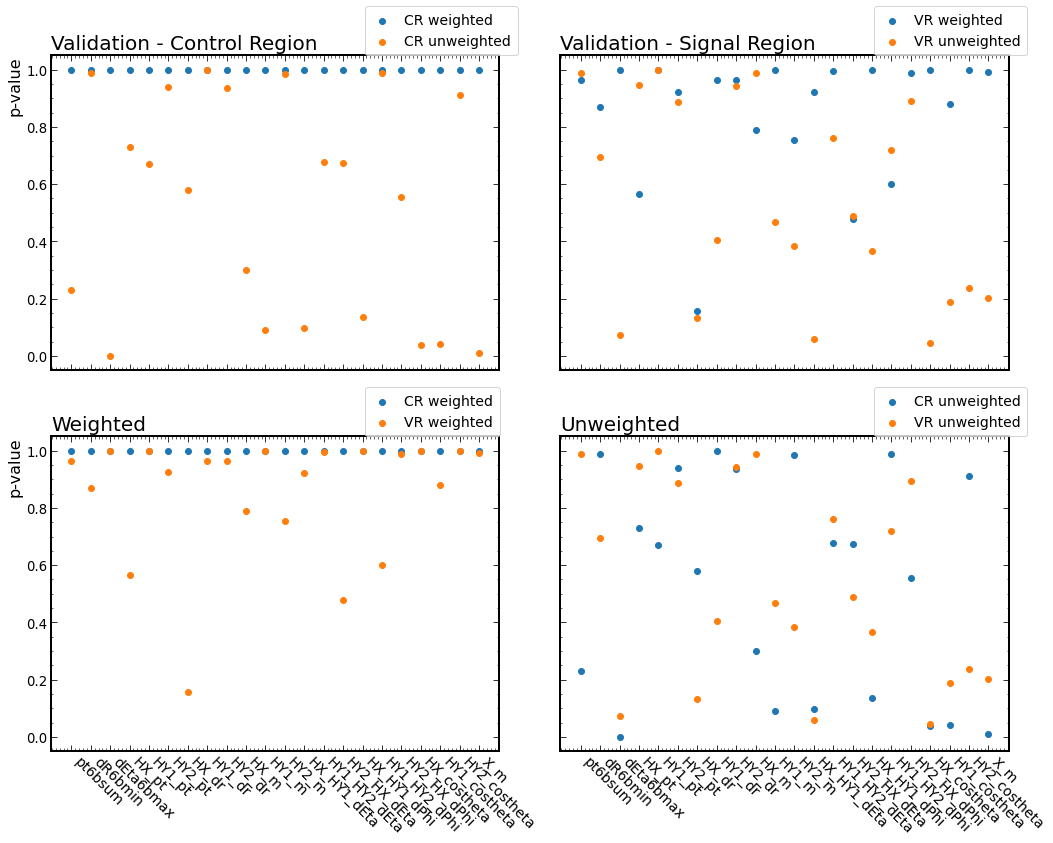

In [45]:
x = np.arange(len(variables))
fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(15,12), sharex=True, sharey=True)

axs[0][0].scatter(x=variables, y=CR_p_w, label="CR weighted")
axs[0][0].scatter(x=variables, y=CR_p_unw, label="CR unweighted")
axs[0][0].set_title('Validation - Control Region', fontsize=20, loc='left')

axs[0][1].scatter(x=variables, y=VR_p_w, label="VR weighted")
axs[0][1].scatter(x=variables, y=VR_p_unw, label="VR unweighted")
axs[0][1].set_title('Validation - Signal Region', fontsize=20, loc='left')

axs[1][0].scatter(x=variables, y=CR_p_w, label="CR weighted")
axs[1][0].scatter(x=variables, y=VR_p_w, label="VR weighted")
axs[1][0].set_title('Weighted', fontsize=20, loc='left')

axs[1][1].scatter(x=variables, y=CR_p_unw, label="CR unweighted")
axs[1][1].scatter(x=variables, y=VR_p_unw, label="VR unweighted")
axs[1][1].set_title('Unweighted', fontsize=20, loc='left')

for ax in axs.flatten():
   ax.legend(loc=(0.7,1), frameon=True, fontsize=14)
axs[1][0].set_xticklabels(variables, ha='left', rotation=-45, fontsize=14)
axs[1][1].set_xticklabels(variables, ha='left', rotation=-45, fontsize=14)
axs[0][0].set_ylabel('p-value')
axs[1][0].set_ylabel('p-value')

fig.tight_layout()
fig.savefig("p_values_noMX.pdf", bbox_inches='tight')

In [19]:
from utils.useCMSstyle import *
plt.style.use(lotsa_plots)

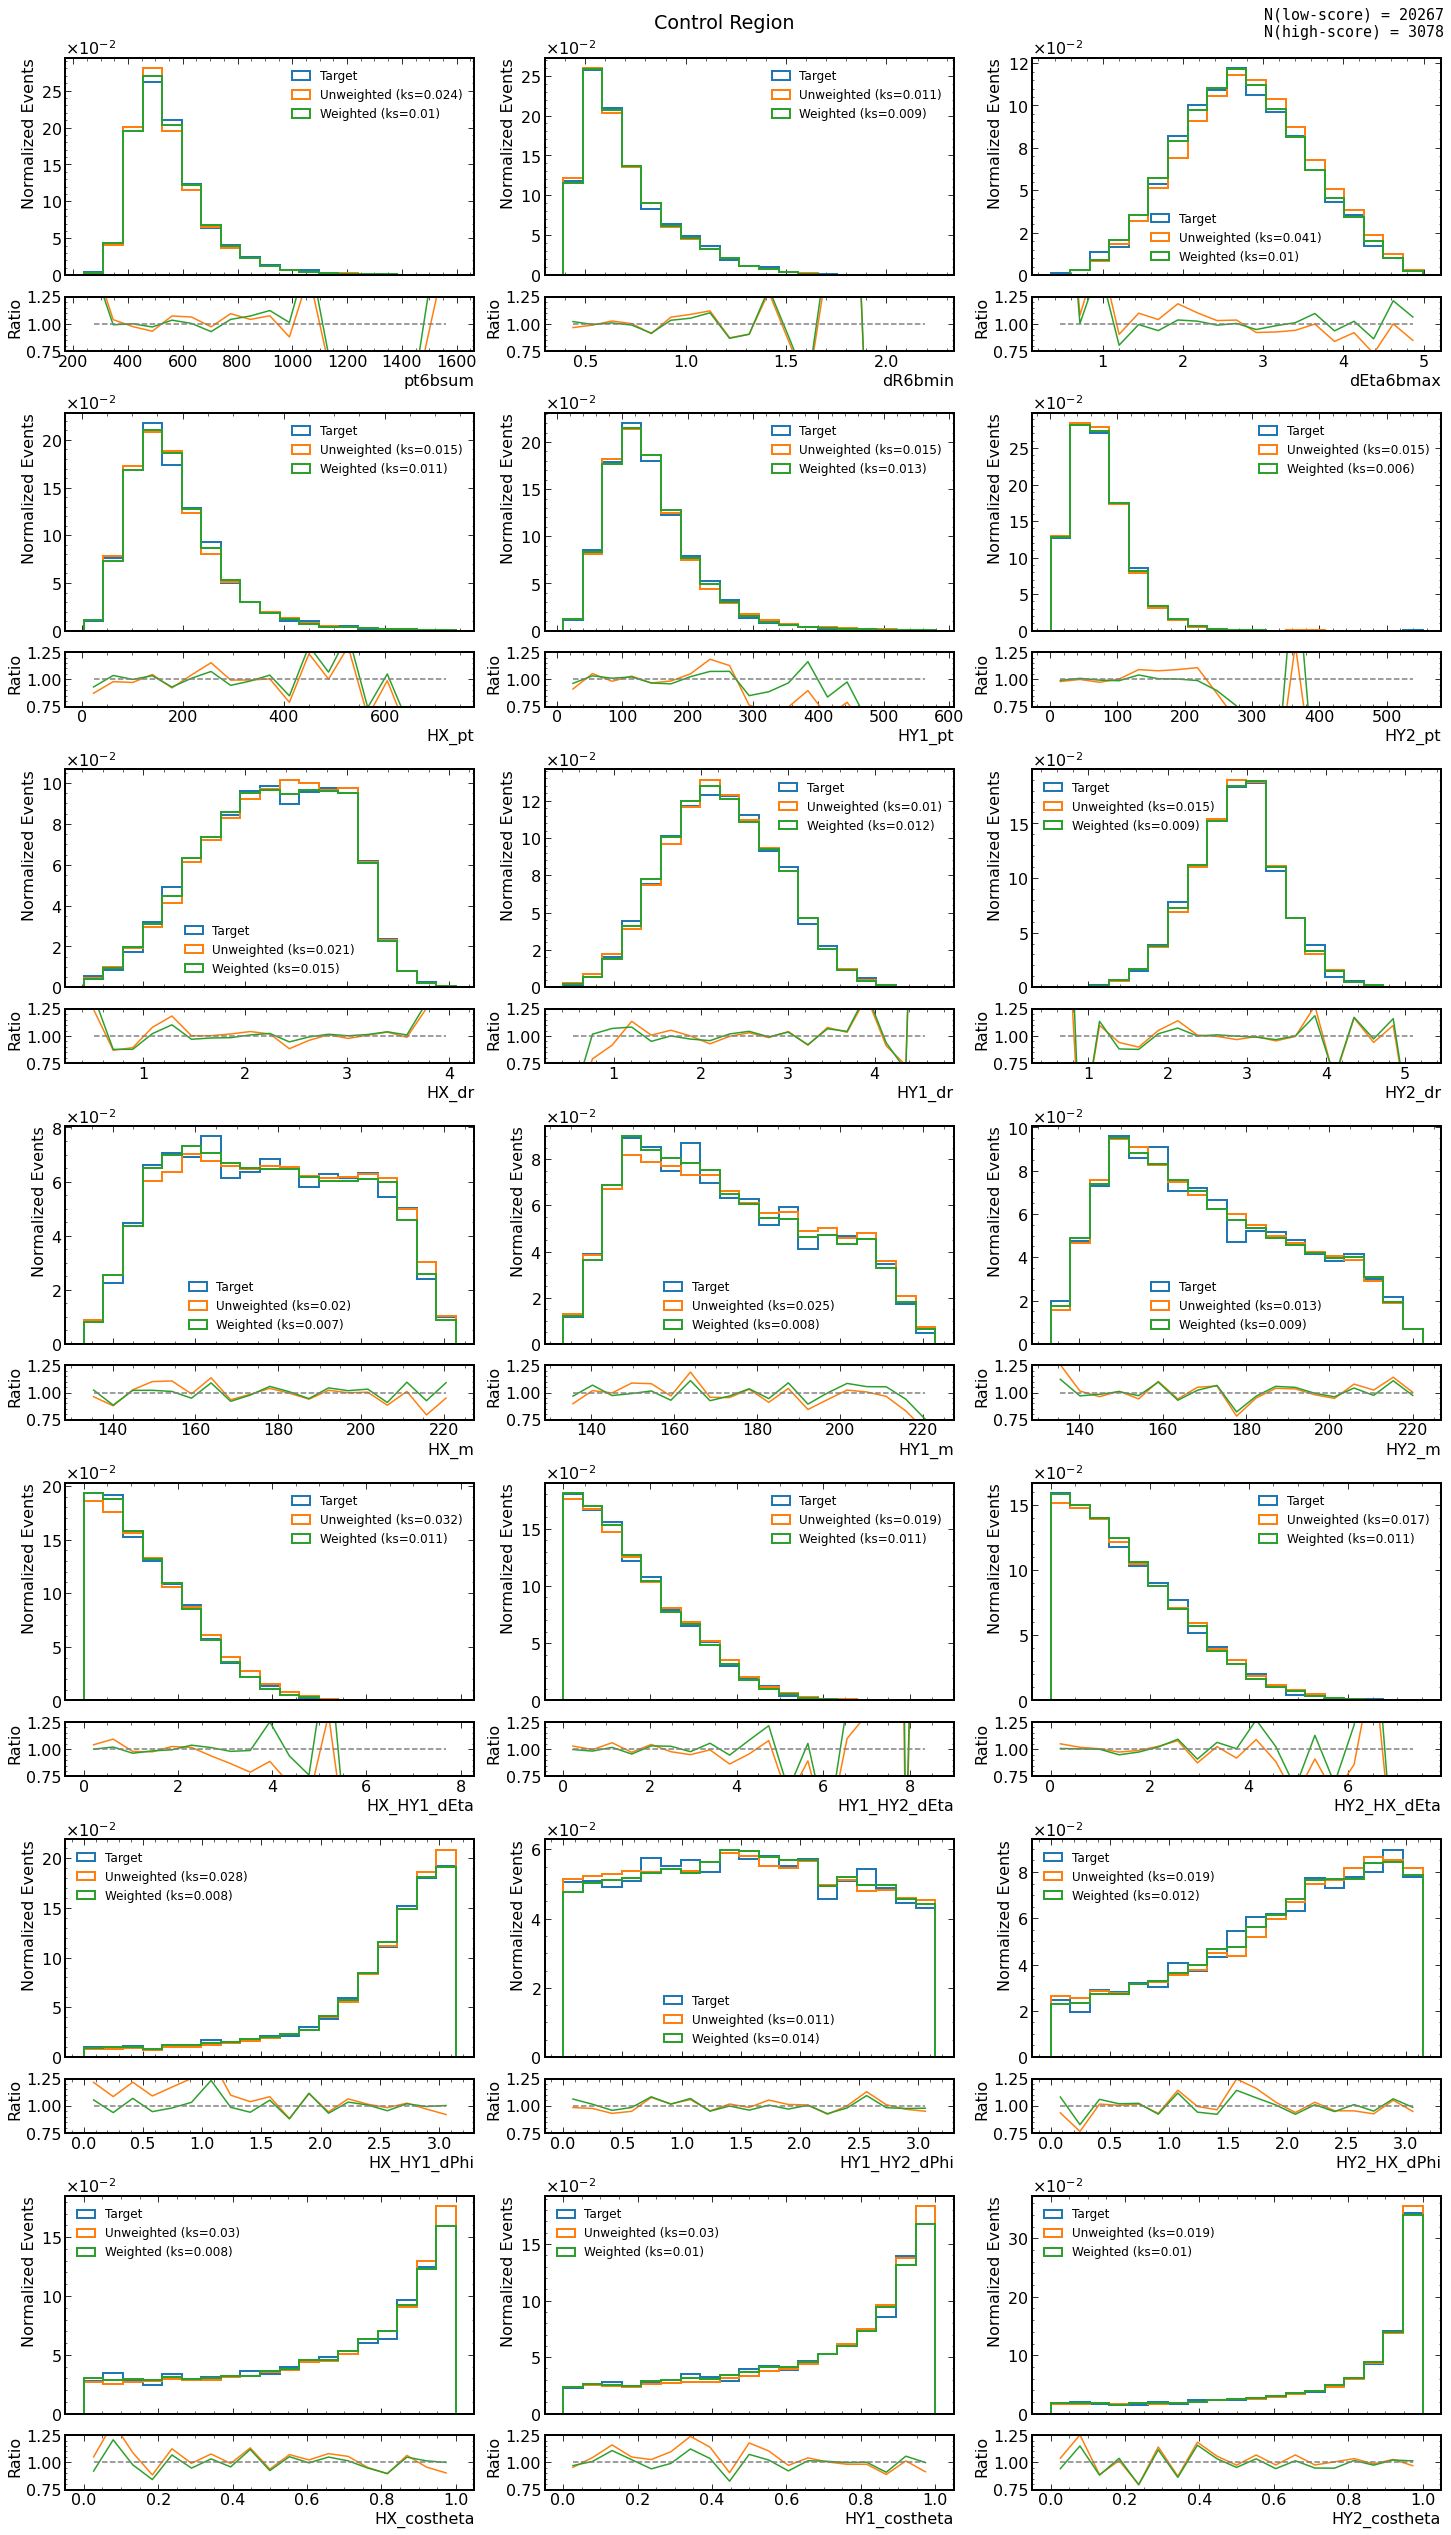

In [23]:
fontsize=16
height_ratios = np.tile([4,1],7)
legend_loc = [1, 1, 8, 1, 1, 1, 8, 1, 2, 8, 8, 8, 1, 1, 1, 2, 8, 2, 2, 2, 2]

N_hs = sum(hs_mask)
N_ls = sum(ls_mask)

fig = plt.figure(constrained_layout=True, figsize=(20,35))
gs = GridSpec(14, 3, figure=fig, height_ratios=height_ratios)

fig.suptitle(t=f"{title}")
fig.text(1, 0.99, f"N(low-score) = {N_ls}\nN(high-score) = {N_hs}", ha='right', transform=fig.transFigure, fontsize=fontsize-1, fontfamily='monospace')

i, j, k = 0, -2, 0
ks_weighted, ks_unweighted = [], []
if 'X_m' in variables: variables = variables[:-1]
for var in variables:
   col = i % 3
   if i % 3 == 0: j += 2
   plot_row = j
   ratio_row = j + 1

   ax1 = fig.add_subplot(gs[plot_row, col])
   ax2 = fig.add_subplot(gs[ratio_row, col], sharex=ax1)
   ax1.tick_params(axis='x', labelbottom=False)

   target = abs(datTree.get(var, 'np'))[datTree.V_CRhs_mask]
   original = abs(datTree.get(var, 'np'))[datTree.V_CRls_mask]


   ks_w = ks_2samp_weighted(original, target, weights1=datTree.CR_weights, weights2=np.ones(len(target)))
   ks_w = round(ks_w, 3)
   ks_weighted.append(ks_w)
   ks_un = ks_2samp_weighted(original, target, weights1=np.ones(len(original)), weights2=np.ones(len(target)))
   ks_un = round(ks_un, 3)
   ks_unweighted.append(ks_un)

   if min(target) < min(original): b_min = min(target)
   else: b_min = min(original)
   if max(target) > max(original): b_max = max(target)
   else: b_max = max(original)
   if b_max >= 1000: b_max = b_max / 2

   bins = np.linspace(b_min,b_max,20)

   n_target     = Hist(target, bins=bins, ax=ax1, label=f'Target', density=1)
   n_unweighted = Hist(original, bins=bins, ax=ax1, label=f'Unweighted (ks={ks_un})', density=1)
   n_weighted   = Hist(original, weights=datTree.CR_weights, bins=bins, ax=ax1, label=f'Weighted (ks={ks_w})', density=1)
   ax1.tick_params(axis='x', labelbottom=False)
   ax1.tick_params(axis='both', labelsize=fontsize)
   ax1.yaxis.offsetText.set_fontsize(fontsize)
   ax1.legend(fontsize=fontsize-4, loc=legend_loc[i])
   # ax1.legend(fontsize=fontsize-4, loc=(0.7,0.9), bbox_transform=ax2.transAxes, frameon=True, fancybox=True, framealpha=1)
   ax1.set_ylabel('Normalized Events', fontsize=fontsize)

   ratio_unweighted = n_target / n_unweighted
   ratio_weighted   = n_target / n_weighted

   x = (bins[:-1] + bins[1:]) / 2
   # r_unweighted = Hist(x, bins=bins, weights=ratio_unweighted, ax=ax2, color='C1')
   ax2.plot(x, ratio_unweighted, color='C1')
   # r_weighted = Hist(x, bins=bins, weights=ratio_weighted, ax=ax2, color='C2')
   ax2.plot(x, ratio_weighted, color='C2')
   ax2.plot(x, [1]*len(x), color='grey', linestyle='--')

   ax2.set_ylabel('Ratio', fontsize=fontsize)
   ax2.set_xlabel(var, fontsize=fontsize)
   ax2.tick_params(axis='both', labelsize=fontsize)
   ax2.yaxis.get_offset_text().set_fontsize(fontsize)
   ax2.set_ylim(0.75,1.25)
# _ = Hist(datTree.X_m[datTree.V_CRls_mask], weights=np.linspace(2,7,sum(datTree.V_CRls_mask)), bins=bins, ax=ax, density=1, label='Wonky')

   i += 1

fig.savefig('plots/bdt_performance/variables_noMX.pdf', bbox_inches='tight')

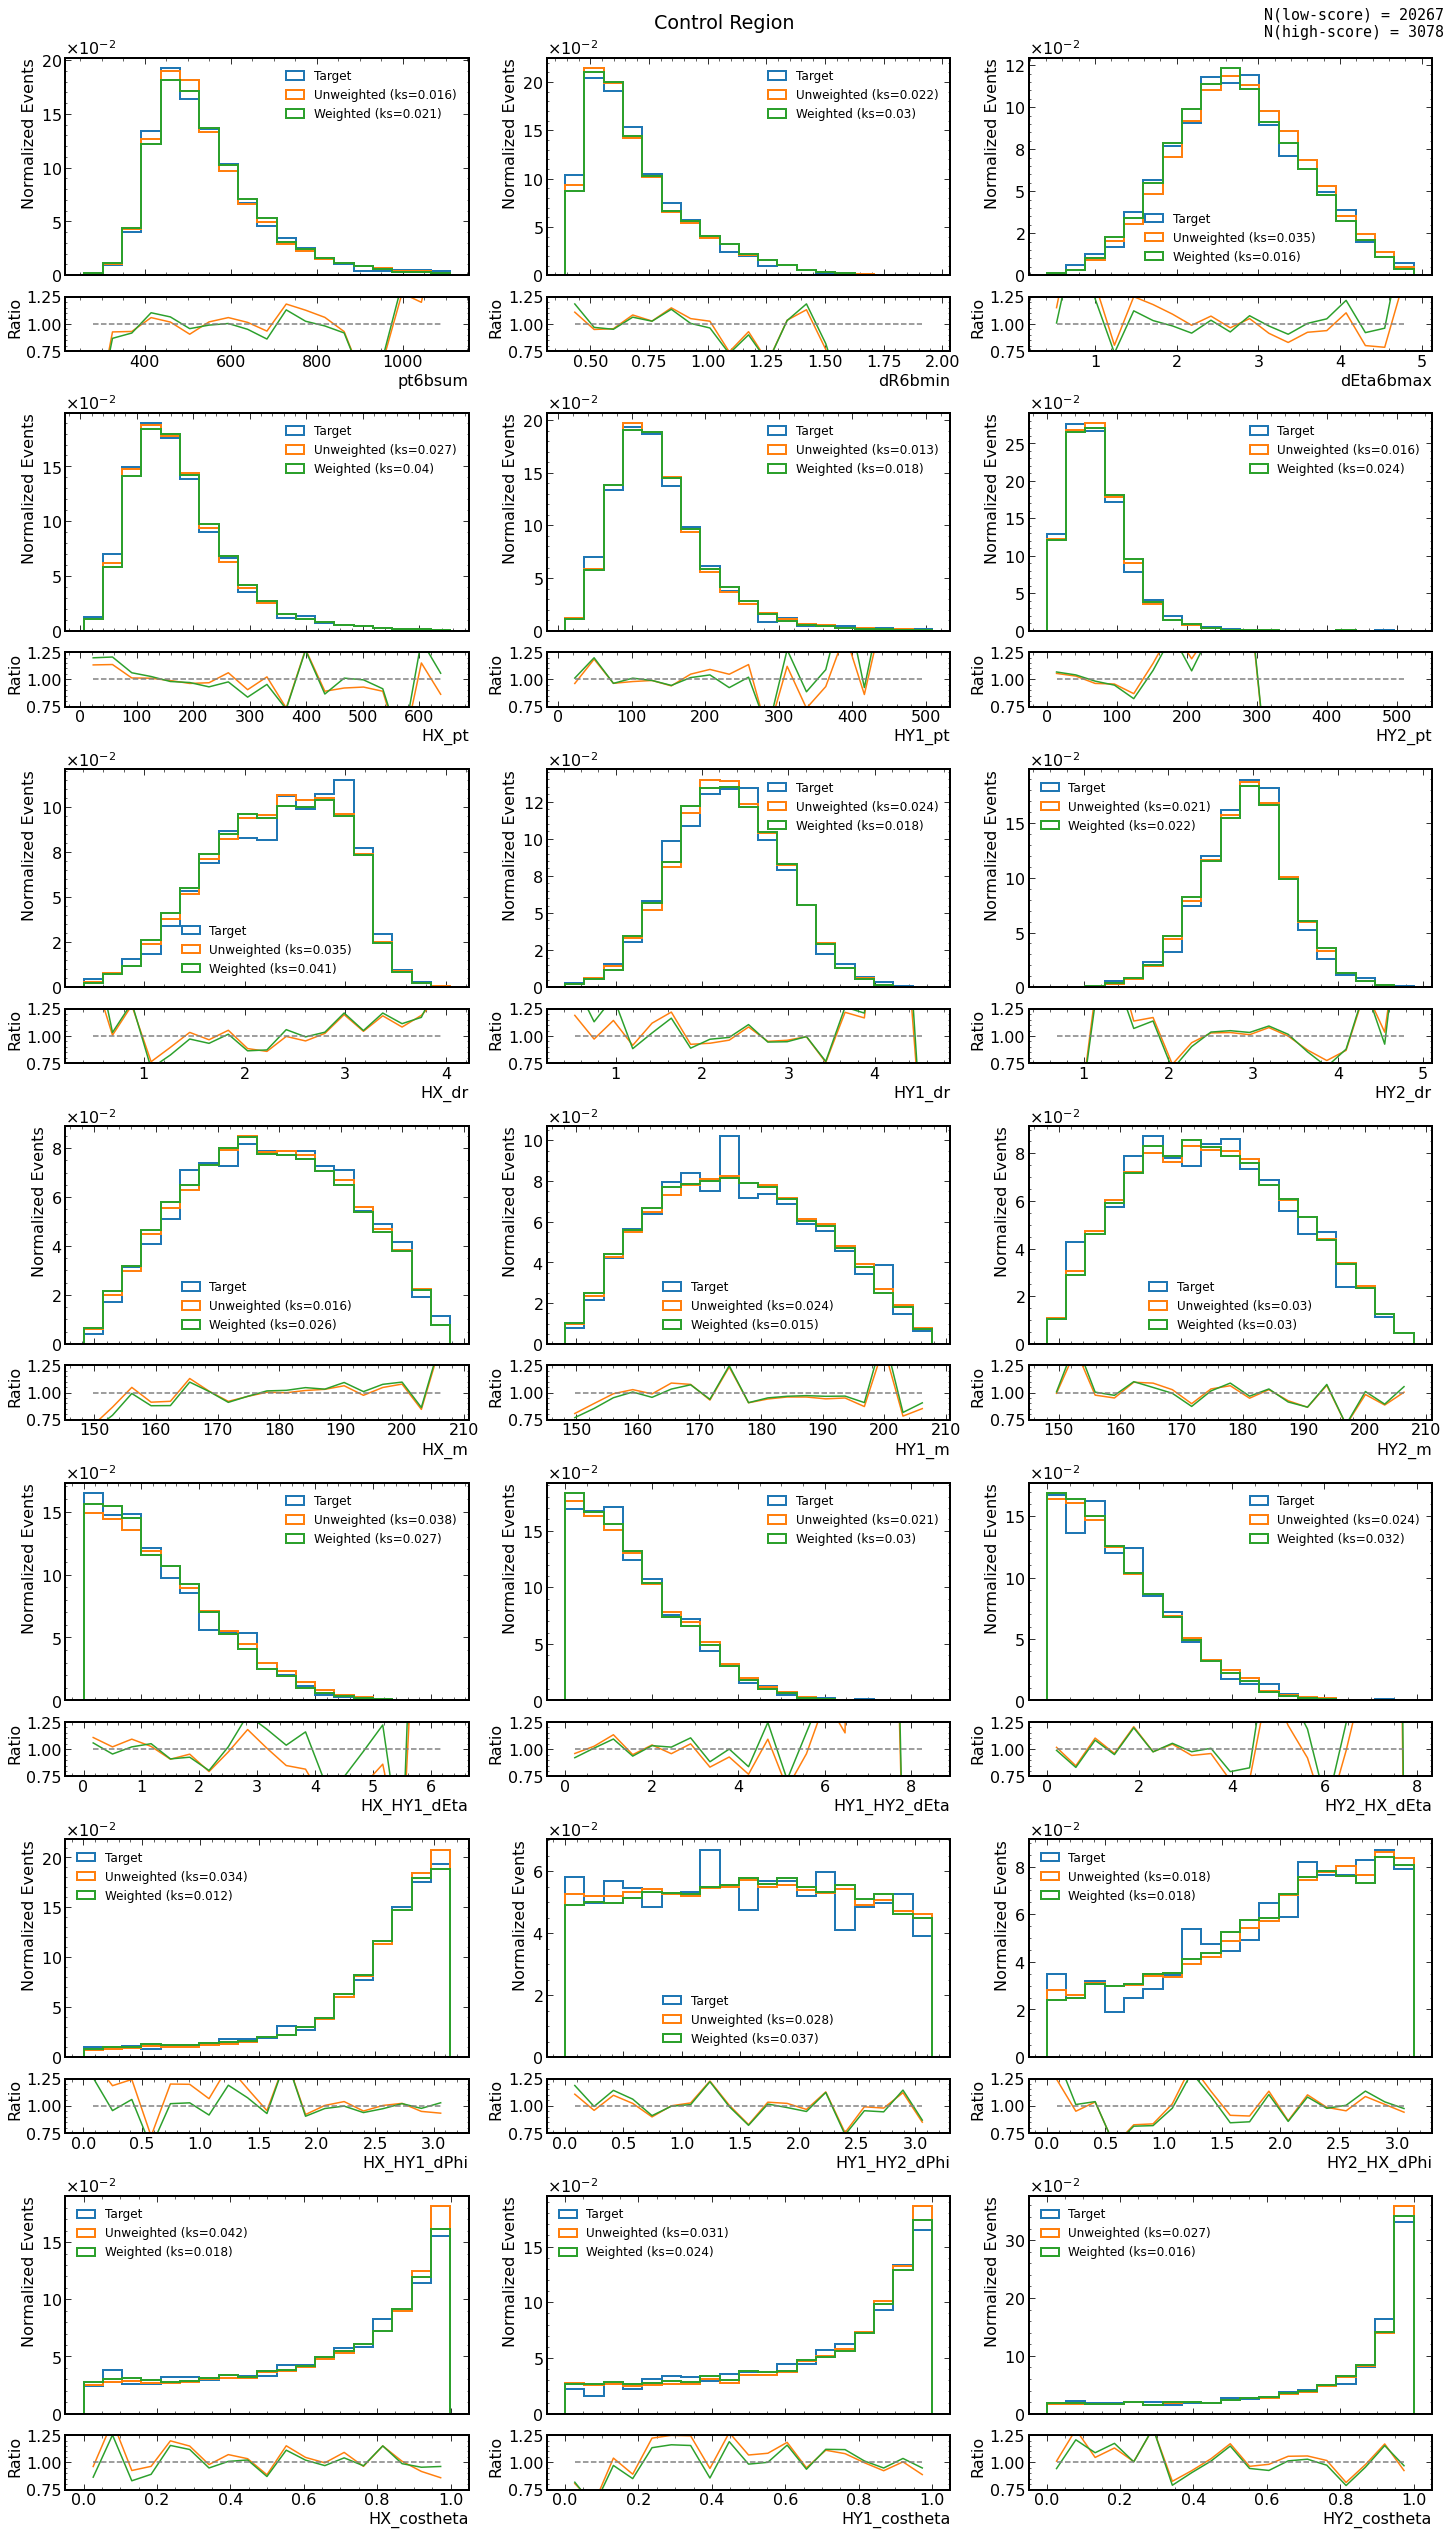

In [46]:
fontsize=16
height_ratios = np.tile([4,1],7)
legend_loc = [1, 1, 8, 1, 1, 1, 8, 1, 2, 8, 8, 8, 1, 1, 1, 2, 8, 2, 2, 2, 2]

N_hs = sum(hs_mask)
N_ls = sum(ls_mask)

fig = plt.figure(constrained_layout=True, figsize=(20,35))
gs = GridSpec(14, 3, figure=fig, height_ratios=height_ratios)

fig.suptitle(t=f"{title}")
fig.text(1, 0.99, f"N(low-score) = {N_ls}\nN(high-score) = {N_hs}", ha='right', transform=fig.transFigure, fontsize=fontsize-1, fontfamily='monospace')

i, j, k = 0, -2, 0
ks_weighted, ks_unweighted = [], []
if 'X_m' in variables: variables = variables[:-1]
for var in variables:
   col = i % 3
   if i % 3 == 0: j += 2
   plot_row = j
   ratio_row = j + 1

   ax1 = fig.add_subplot(gs[plot_row, col])
   ax2 = fig.add_subplot(gs[ratio_row, col], sharex=ax1)
   ax1.tick_params(axis='x', labelbottom=False)

   target = abs(datTree.get(var, 'np'))[datTree.V_SRhs_mask]
   original = abs(datTree.get(var, 'np'))[datTree.V_SRls_mask]


   ks_w = ks_2samp_weighted(original, target, weights1=datTree.VR_weights, weights2=np.ones(len(target)))
   ks_w = round(ks_w, 3)
   ks_weighted.append(ks_w)
   ks_un = ks_2samp_weighted(original, target, weights1=np.ones(len(original)), weights2=np.ones(len(target)))
   ks_un = round(ks_un, 3)
   ks_unweighted.append(ks_un)

   if min(target) < min(original): b_min = min(target)
   else: b_min = min(original)
   if max(target) > max(original): b_max = max(target)
   else: b_max = max(original)
   if b_max >= 1000: b_max = b_max / 2

   bins = np.linspace(b_min,b_max,20)

   n_target     = Hist(target, bins=bins, ax=ax1, label=f'Target', density=1)
   n_unweighted = Hist(original, bins=bins, ax=ax1, label=f'Unweighted (ks={ks_un})', density=1)
   n_weighted   = Hist(original, weights=datTree.VR_weights, bins=bins, ax=ax1, label=f'Weighted (ks={ks_w})', density=1)
   ax1.tick_params(axis='x', labelbottom=False)
   ax1.tick_params(axis='both', labelsize=fontsize)
   ax1.yaxis.offsetText.set_fontsize(fontsize)
   ax1.legend(fontsize=fontsize-4, loc=legend_loc[i])
   # ax1.legend(fontsize=fontsize-4, loc=(0.7,0.9), bbox_transform=ax2.transAxes, frameon=True, fancybox=True, framealpha=1)
   ax1.set_ylabel('Normalized Events', fontsize=fontsize)

   ratio_unweighted = n_target / n_unweighted
   ratio_weighted   = n_target / n_weighted

   x = (bins[:-1] + bins[1:]) / 2
   # r_unweighted = Hist(x, bins=bins, weights=ratio_unweighted, ax=ax2, color='C1')
   ax2.plot(x, ratio_unweighted, color='C1')
   # r_weighted = Hist(x, bins=bins, weights=ratio_weighted, ax=ax2, color='C2')
   ax2.plot(x, ratio_weighted, color='C2')
   ax2.plot(x, [1]*len(x), color='grey', linestyle='--')

   ax2.set_ylabel('Ratio', fontsize=fontsize)
   ax2.set_xlabel(var, fontsize=fontsize)
   ax2.tick_params(axis='both', labelsize=fontsize)
   ax2.yaxis.get_offset_text().set_fontsize(fontsize)
   ax2.set_ylim(0.75,1.25)
# _ = Hist(datTree.X_m[datTree.V_VRls_mask], weights=np.linspace(2,7,sum(datTree.V_VRls_mask)), bins=bins, ax=ax, density=1, label='Wonky')

   i += 1

# fig.savefig('plots/bdt_performance/variables_noMX.pdf', bbox_inches='tight')

<ipython-input-47-93da3d77591a>:10: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(variables, fontdict={'rotation':-45, 'ha':'left'})


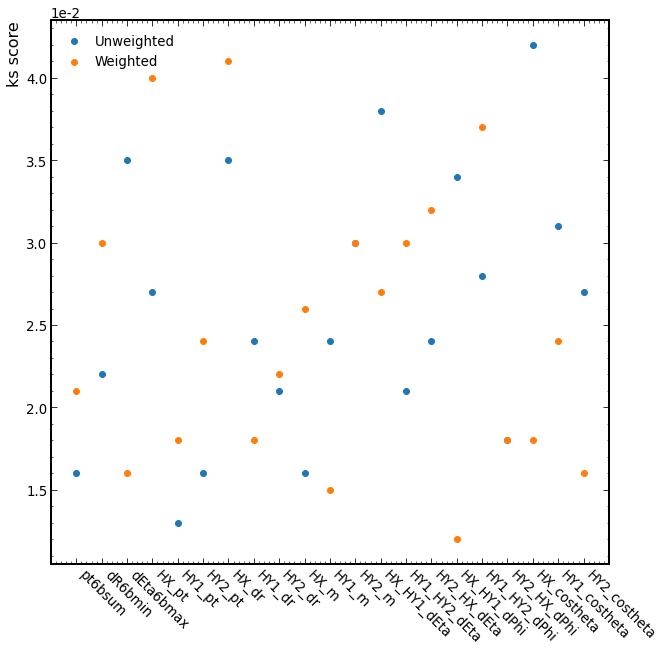

In [47]:
x = np.arange(len(ks_unweighted))

fig, ax = plt.subplots()

ax.scatter(variables, ks_unweighted, label='Unweighted')
ax.scatter(variables, ks_weighted, label='Weighted')

ax.legend()
ax.set_ylabel('ks score')
ax.set_xticklabels(variables, fontdict={'rotation':-45, 'ha':'left'})
plt.show()



In [ ]:
train_mask, test_mask = train_test_split(range(len(data)), test_size=0.33)

In [78]:
N = int(len(test_mask)/2)

In [79]:
train_mask = np.append(train_mask, test_mask[:N])
test_mask = test_mask[N:]

In [80]:
len(test_mask)/len(train_mask)

0.19760939824552404

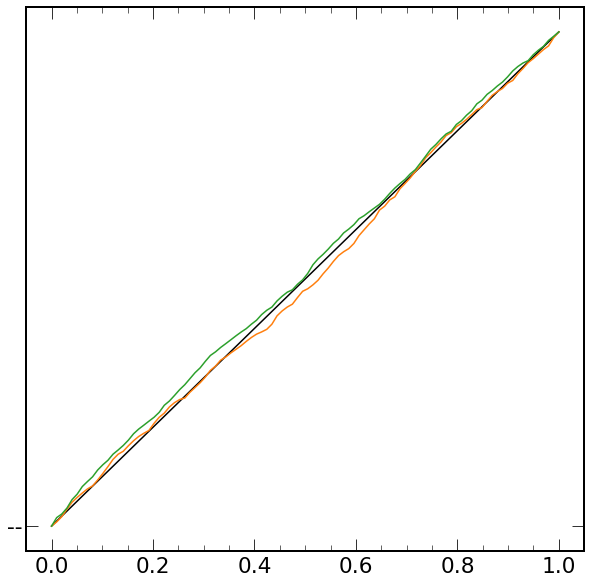

In [ ]:
fig, ax = plt.subplots()
ax.plot([0,1],[0,1],'k')
ax.plot(mean_fpr, tprs[0])
ax.plot(mean_fpr, tprs[1])

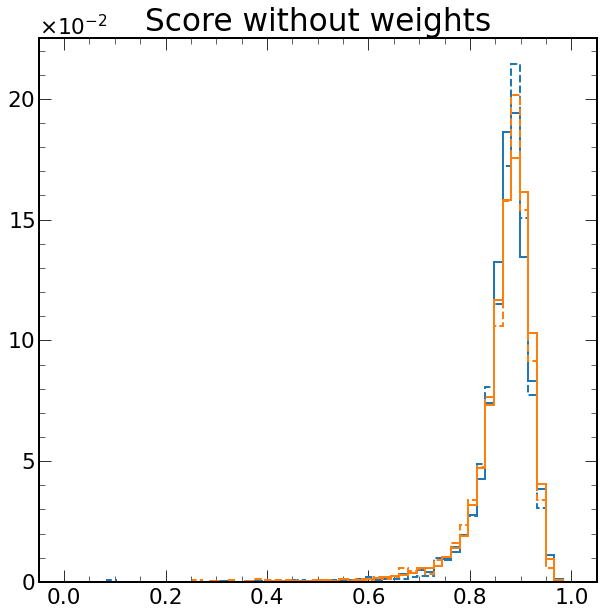

In [50]:
fig, ax = plt.subplots()
ax.set_title("Score without weights")
_ = Hist(probs_model[0][:,1], bins=np.linspace(0,1,60), ax=ax, color='C0', density=1)
_ = Hist(probs_target[0][:,1], bins=np.linspace(0,1,60), ax=ax, color='C0', ls='--', density=1)
_ = Hist(probs_model[1][:,1], bins=np.linspace(0,1,60), ax=ax, color='C1', density=1)
_ = Hist(probs_target[1][:,1], bins=np.linspace(0,1,60), ax=ax, color='C1', ls='--', density=1)

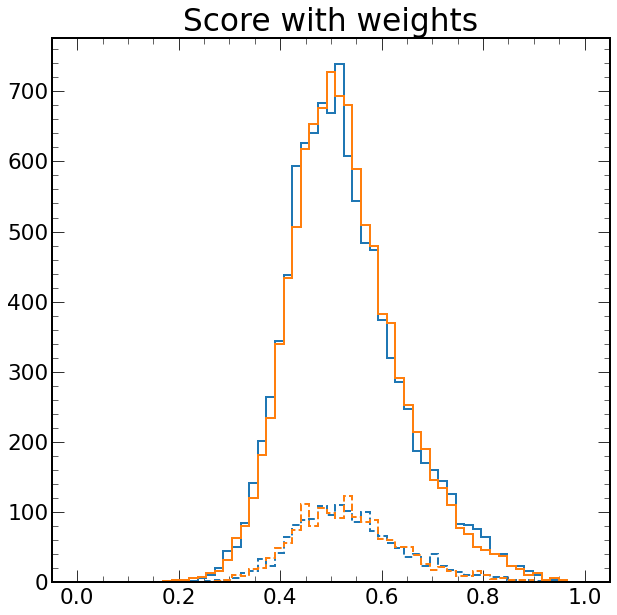

In [47]:
fig, ax = plt.subplots()
ax.set_title("Score with weights")
_ = Hist(probs_model[0][:,1], bins=np.linspace(0,1,60), ax=ax, color='C0')
_ = Hist(probs_target[0][:,1], bins=np.linspace(0,1,60), ax=ax, color='C0', ls='--')
_ = Hist(probs_model[1][:,1], bins=np.linspace(0,1,60), ax=ax, color='C1')
_ = Hist(probs_target[1][:,1], bins=np.linspace(0,1,60), ax=ax, color='C1', ls='--')

In [5]:
mean_auc # subsample -> 0.62

0.879

Original was 0.811

In [15]:
mean_tprs = np.vstack(tprs).mean(axis=0)

NameError: name 'mean_fpr' is not defined

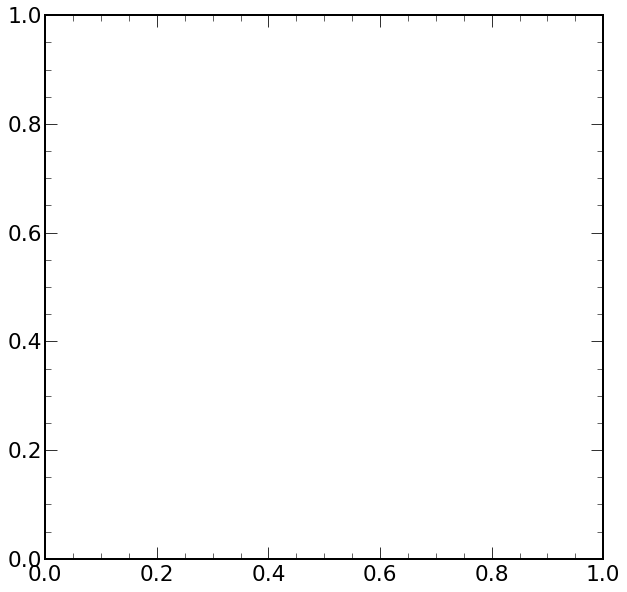

In [2]:
fig, ax = plt.subplots()

ax.plot(mean_fpr, mean_tprs)
ax.set_xlabel("False Positive Rate")
ax.set_ylabel("True Positive Rate")

In [13]:
np.linspace(100,500,len(x_CRls))

array([100.        , 100.01973749, 100.03947498, ..., 499.96052502,
       499.98026251, 500.        ])

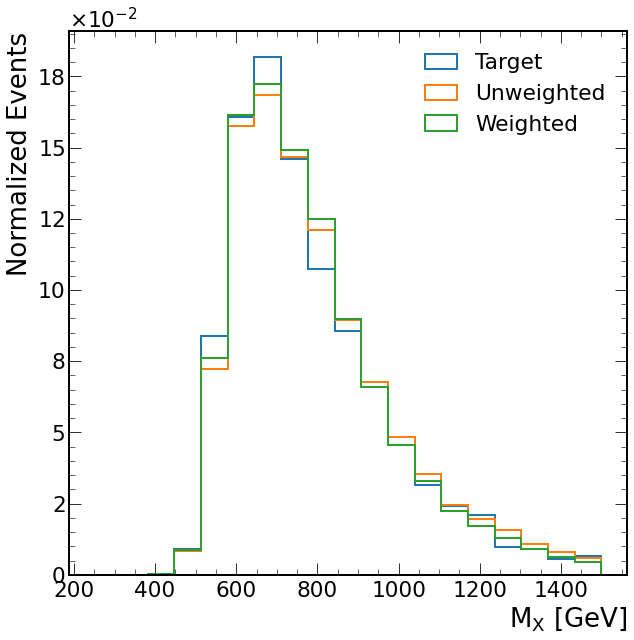

In [103]:
fig, ax = plt.subplots()
bins = np.linspace(250,1500,20)
Hist(datTree.X_m[datTree.V_SRhs_mask], bins=bins, ax=ax, label='Target', density=1, lw=3)
n = Hist(datTree.X_m[datTree.V_SRls_mask], bins=bins, ax=ax, label='Unweighted', density=1)
_ = Hist(datTree.X_m[datTree.V_SRls_mask], weights=datTree.VR_weights, bins=bins, ax=ax, label='Weighted', density=1)
# ax.set_xticks(x, labels=labels, fontsize=24, rotation=-25, ha='left')
ax.set_xlabel(r'$M_X$ [GeV]')
ax.set_ylabel('Normalized Events')
# _ = Hist(datTree.X_m[datTree.V_VRls_mask], weights=np.linspace(2,7,sum(datTree.V_VRls_mask)), bins=bins, ax=ax, density=1, label='Wonky')
ax.legend()

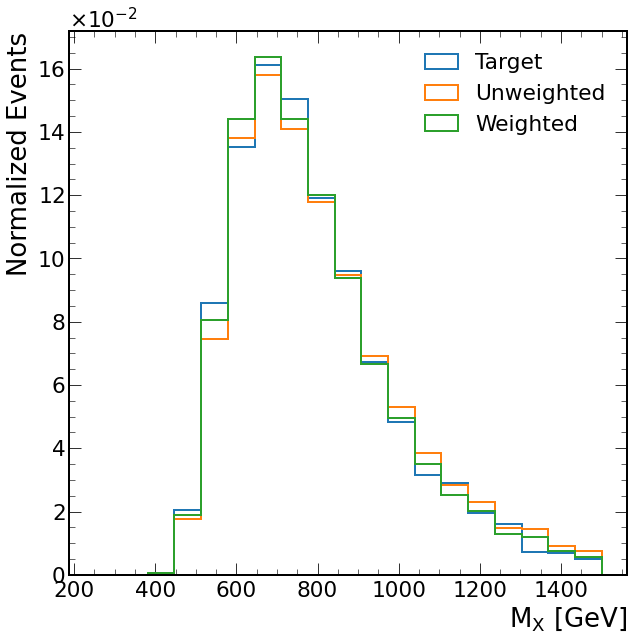

In [95]:
fig, ax = plt.subplots()
bins = np.linspace(250,1500,20)
Hist(datTree.X_m[datTree.V_CRhs_mask], bins=bins, ax=ax, label='Target', density=1)
n = Hist(datTree.X_m[datTree.V_CRls_mask], bins=bins, ax=ax, label='Unweighted', density=1)
_ = Hist(datTree.X_m[datTree.V_CRls_mask], weights=datTree.CR_weights, bins=bins, ax=ax, label='Weighted', density=1)
# ax.set_xticks(x, labels=labels, fontsize=24, rotation=-25, ha='left')
ax.set_xlabel(r'$M_X$ [GeV]')
ax.set_ylabel('Normalized Events')
# _ = Hist(datTree.X_m[datTree.V_CRls_mask], weights=np.linspace(2,7,sum(datTree.V_CRls_mask)), bins=bins, ax=ax, density=1, label='Wonky')
ax.legend()

In [ ]:
fig, ax = plt.subplots()

Hist(datTree.X_m[datTree.V_CRhs_mask], bins=bins, ax=ax, density=1, label='Target')
Hist(datTree.X_m[datTree.V_CRls_mask], bins=bins, ax=ax, density=1, label='Unweighted')
_ = Hist(datTree.X_m[datTree.V_CRls_mask], weights=datTree.CR_weights, bins=bins, ax=ax, density=1, label='Weighted')
# _ = Hist(datTree.X_m[datTree.V_CRls_mask], weights=np.linspace(2,7,sum(datTree.V_CRls_mask)), bins=bins, ax=ax, density=1, label='Wonky')
ax.legend()

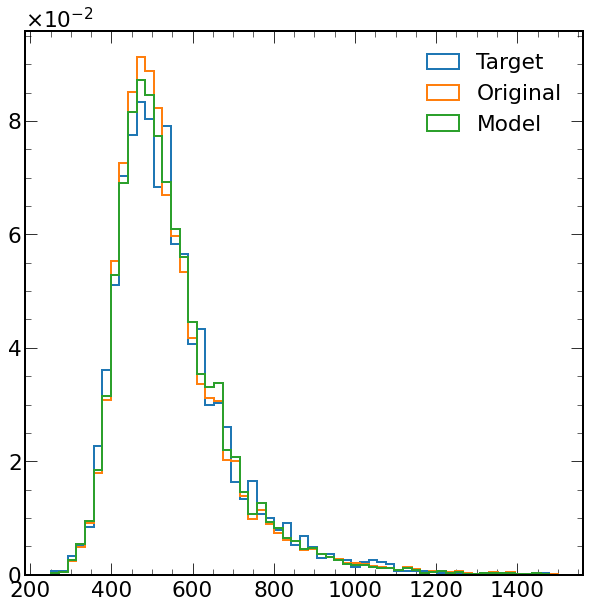

In [18]:
fig, ax = plt.subplots()
bins = np.linspace(250,1500,60)
_ = Hist(x_CRhs[:,0], bins=bins, ax=ax, density=1, label='Target')
Hist(datTree.get(variables[0])[datTree.V_SRls_mask], bins=bins, ax=ax, density=1, label='Original')
_ = Hist(datTree.get(variables[0])[datTree.V_SRls_mask], weights=datTree.VR_weights, bins=bins, ax=ax, density=1, label='Model')
ax.legend()

In [ ]:
cfg = 'config/rectConfig.cfg'

### ------------------------------------------------------------------------------------
## Implement config parser

config = ConfigParser()
config.optionxform = str
config.read(cfg)

base = config['file']['base']
signal = config['file']['signal']
data = config['file']['data']
treename = config['file']['tree']
year = int(config['file']['year'])
pairing = config['pairing']['scheme']
pairing_type = pairing.split('_')[0]

variables = config['BDT']['variables']
variables = variables.split(', ')

score = float(config['score']['threshold'])

In [ ]:
region_type = 'rect'
datTree.rectangular_region(config)
VR_weights, SR_weights = datTree.bdt_process(region_type, config)
datTree.CR_weights

In [1]:
import matplotlib.patches as mpatches

In [2]:
h_signal = 'oo'
h_control = 'XX'

signal_region = mpatches.Patch(color='black', fill=False, hatch=h_signal, alpha=0.5, label='Signal Region')
control_region = mpatches.Patch(color='black', fill=False, hatch=h_control, alpha=0.5, label='Control Region')

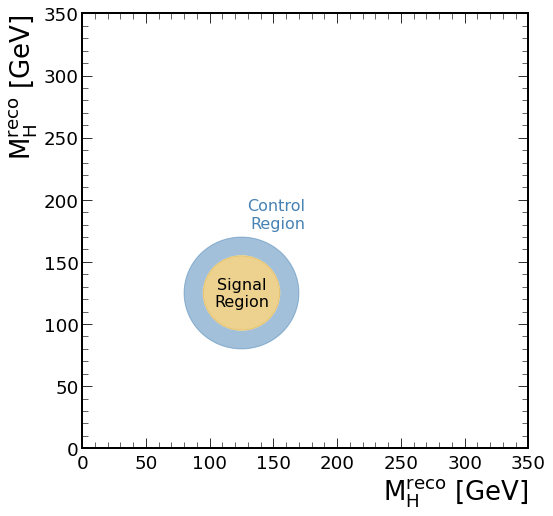

In [19]:
SR_color = 'goldenrod'
CR_color = 'steelblue'
SR_text = 'black'
CR_text = CR_color

Ac = 125
Vc = 178

fig, ax = plt.subplots()

circle3 = plt.Circle((Ac, Ac), 30, alpha=0.5, color=SR_color)
circle_a = plt.Circle((Ac, Ac), 30, color='white')
circle4 = plt.Circle((Ac, Ac), 45, alpha=0.5, color=CR_color)

ax.add_patch(circle4)
ax.add_patch(circle_a)
ax.add_patch(circle3)

ax.text(Ac, Ac, 'Signal\nRegion', ha='center', va='center', fontsize=16, color='black')
ax.text(175, 175, 'Control\nRegion', ha='right', va='bottom', fontsize=16, color=CR_color)

ax.set_ylim(0, 350)
ax.set_xlim(0, 350)

ax.set_xlabel(r"M$_\mathrm{H}^\mathrm{reco}$ [GeV]", fontsize=26)
ax.set_ylabel(r"M$_\mathrm{H}^\mathrm{reco}$ [GeV]", fontsize=26)

fig.savefig("plots/diagrams/signal_control_regions.pdf")

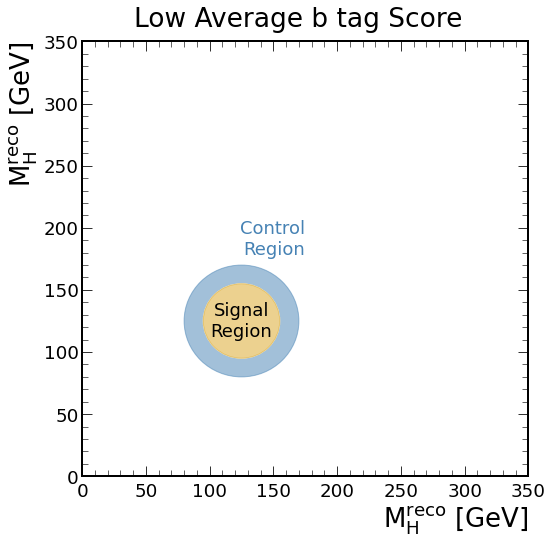

In [21]:
Ac = 125
Vc = 178

fig, ax = plt.subplots()
fig.suptitle("Low Average b tag Score", y=0.94)

circle3 = plt.Circle((Ac, Ac), 30, alpha=0.5, color=SR_color)
circle_a = plt.Circle((Ac, Ac), 30, color='white')
circle4 = plt.Circle((Ac, Ac), 45, alpha=0.5, color=CR_color)

ax.add_patch(circle4)
ax.add_patch(circle_a)
ax.add_patch(circle3)

ax.text(Ac, Ac, 'Signal\nRegion', ha='center', va='center', fontsize=18, color=SR_text)
ax.text(175, 175, 'Control\nRegion', ha='right', va='bottom', fontsize=18, color=CR_text)

ax.set_ylim(0, 350)
ax.set_xlim(0, 350)

ax.set_xlabel(r"M$_\mathrm{H}^\mathrm{reco}$ [GeV]", fontsize=26)
ax.set_ylabel(r"M$_\mathrm{H}^\mathrm{reco}$ [GeV]", fontsize=26)

fig.savefig("plots/diagrams/low_b_regions.pdf")

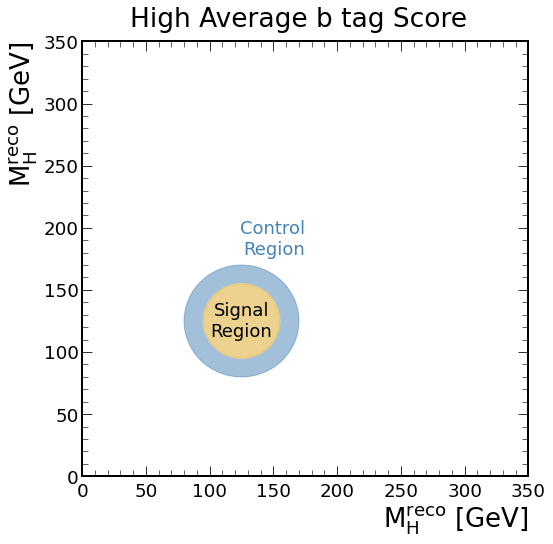

In [22]:
Ac = 125
Vc = 178

fig, ax = plt.subplots()
fig.suptitle("High Average b tag Score", y=0.94)

circle3 = plt.Circle((Ac, Ac), 30, alpha=0.5, color=SR_color)
circle_a = plt.Circle((Ac, Ac), 30, color='white')
circle4 = plt.Circle((Ac, Ac), 45, alpha=0.5, color=CR_color)

ax.add_patch(circle4)
ax.add_patch(circle_a)
ax.add_patch(circle3)

ax.text(Ac, Ac, 'Signal\nRegion', ha='center', va='center', fontsize=18, color=SR_text)
ax.text(175, 175, 'Control\nRegion', ha='right', va='bottom', fontsize=18, color=CR_text)

ax.set_ylim(0, 350)
ax.set_xlim(0, 350)

ax.set_xlabel(r"M$_\mathrm{H}^\mathrm{reco}$ [GeV]", fontsize=26)
ax.set_ylabel(r"M$_\mathrm{H}^\mathrm{reco}$ [GeV]", fontsize=26)

fig.savefig("plots/diagrams/high_b_regions.pdf")

In [34]:
h_signal = 'oo'
h_control = 'XX'

a_signal_region = mpatches.Patch(color=SR_color, alpha=0.5, label='Analysis Signal Region')
a_control_region = mpatches.Patch(color=CR_color, alpha=0.5, label='Analysis Control Region')
v_signal_region = mpatches.Patch(color='peru', alpha=0.5, label='Validation Signal Region')
v_control_region = mpatches.Patch(color='cadetblue', alpha=0.5, label='Validation Control Region')

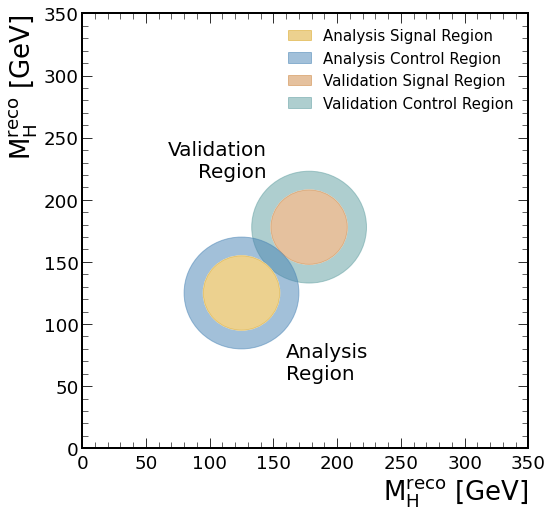

In [36]:
Ac = 125
Vc = 178

fig, ax = plt.subplots()

circle2 = plt.Circle((Vc, Vc), 45, color='cadetblue', alpha=0.5)
circle_v = plt.Circle((Vc, Vc), 30, color='white')
circle1 = plt.Circle((Vc, Vc), 30, color='peru', alpha=0.5)

circle4 = plt.Circle((Ac, Ac), 45, color=CR_color, alpha=0.5)
circle_a = plt.Circle((Ac, Ac), 30, color='white')
circle3 = plt.Circle((Ac, Ac), 30, color=SR_color, alpha=0.5)
ax.add_patch(circle2)
ax.add_patch(circle_v)
ax.add_patch(circle1)
ax.add_patch(circle4)
ax.add_patch(circle_a)
ax.add_patch(circle3)

ax.text(145, 215, 'Validation\nRegion', ha='right', va='bottom', fontsize=20, color='k')
ax.text(160, 85, 'Analysis\nRegion', ha='left', va='top', fontsize=20, color='k')

plt.legend(handles=[a_signal_region, a_control_region, v_signal_region, v_control_region], fontsize=15)

ax.set_ylim(0, 350)
ax.set_xlim(0, 350)

ax.set_xlabel(r"M$_\mathrm{H}^\mathrm{reco}$ [GeV]", fontsize=26)
ax.set_ylabel(r"M$_\mathrm{H}^\mathrm{reco}$ [GeV]", fontsize=26)

fig.savefig("plots/diagrams/analysis_validation_regions.pdf")

In [11]:
filename = FileLocations().get_NMSSM(700, 400)

In [12]:
tree = Signal(filename)
tree.spherical_region(config)
signal_btag = tree.np('jet_btag')
signal_btag = [line[:6] for line in signal_btag]
signal_btag = np.array([np.average(line) for line in signal_btag])

In [ ]:
datTree.spherical_region(config)

data_btag = datTree.np('jet_btag')
data_btag = [line[:6] for line in data_btag]
data_btag = np.array([np.average(line) for line in data_btag])

In [40]:
data_b_vcr = data_btag[np.logical_or(datTree.V_CRls_mask, datTree.V_CRhs_mask)]
data_b_vcrls = data_btag[datTree.V_CRls_mask]
data_b_vcrhs = data_btag[datTree.V_CRhs_mask]

In [41]:
signal_b_vcr = signal_btag[np.logical_or(tree.V_CRls_mask, tree.V_CRhs_mask)]
signal_b_vcrls = signal_btag[tree.V_CRls_mask]
signal_b_vcrhs = signal_btag[tree.V_CRhs_mask]

In [18]:
score_bins = np.linspace(0,1.01,100)
fig, ax = plt.subplots()

Hist(data_b_vcr, bins=score_bins, ax=ax)

array([False, False, False, ..., False, False,  True])